# Importing Libraries

In [1]:
import torch
import pathlib
import random
import cv2
import gc
import sys
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.model_selection as ms
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import albumentations as A
import shutil


from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, accuracy_score, classification_report
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor
from pathlib import Path
from albumentations.pytorch import ToTensorV2
from torch.utils.data import WeightedRandomSampler




SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Fixing one of the most annoying "features" of opencv
cv2.ocl.setUseOpenCL(False)
cv2.setNumThreads(0)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Mounting Google Drive and Extracting Data

This step assumes that you have the dataset in your Google Drive.

In [2]:
# This will mount your google drive folder
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%%time

# Define paths
DATA_DIR = '/content/data'
os.makedirs(DATA_DIR, exist_ok=True)

# Extract the dataset
!unzip -q /content/drive/MyDrive/aptos2019.zip -d {DATA_DIR}

CPU times: user 518 ms, sys: 78.9 ms, total: 596 ms
Wall time: 1min 34s


In [5]:
!ls /content/data/

test.csv  test_images  train_1.csv  train_images  valid.csv  val_images


### Loading and Exploring Data

In this section, I have:

- Uploaded the training, validation, and test datasets, examined their structure, and analyzed class distributions.
- Observed a significant class imbalance, with class `0` making up nearly half of the dataset.
- Combined the training and validation datasets to create stratified folds for cross-validation, ensuring no data leakage.

In [6]:
# Define file paths
TRAIN_CSV = f'{DATA_DIR}/train_1.csv'
VALID_CSV = f'{DATA_DIR}/valid.csv'
TEST_CSV = f'{DATA_DIR}/test.csv'

# Load data with error handling
def load_csv(file_path):
    """Load a CSV file and handle errors gracefully."""
    try:
        df = pd.read_csv(file_path)
        print(f"Loaded {file_path} successfully. Shape: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"Error: {file_path} not found!")
        sys.exit(1)

# Load datasets
train_df = load_csv(TRAIN_CSV)
valid_df = load_csv(VALID_CSV)
test_df = load_csv(TEST_CSV)

# Display dataset information
print("Train Data Preview:")
print(train_df.head(), "\n")
print(f"Training Set Size: {train_df.shape[0]} samples")
print(f"Validation Set Size: {valid_df.shape[0]} samples")

Loaded /content/data/train_1.csv successfully. Shape: (2930, 2)
Loaded /content/data/valid.csv successfully. Shape: (366, 2)
Loaded /content/data/test.csv successfully. Shape: (366, 2)
Train Data Preview:
        id_code  diagnosis
0  1ae8c165fd53          2
1  1b329a127307          1
2  1b32e1d775ea          4
3  1b3647865779          0
4  1b398c0494d1          0 

Training Set Size: 2930 samples
Validation Set Size: 366 samples


In [7]:
# Define Image Paths
TRAIN_IMAGES_DIR = '/content/data/train_images/train_images/'
VAL_IMAGES_DIR = '/content/data/val_images/val_images/'
TEST_IMAGES_DIR = '/content/data/test_images/test_images/'

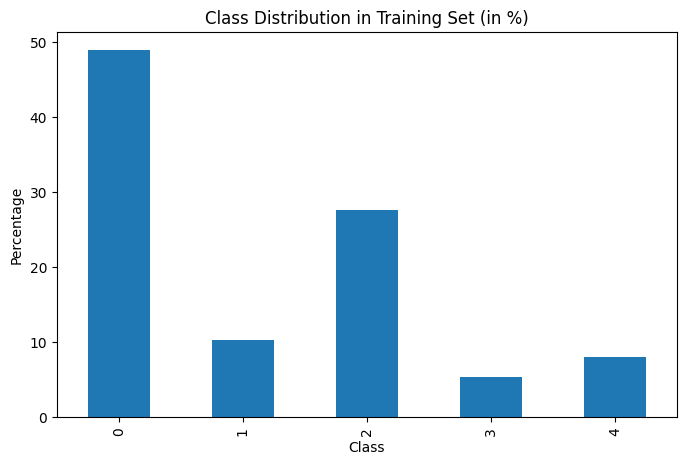

Class Distribution in Training Set (in %):
diagnosis
0    48.94
2    27.58
1    10.24
4     7.99
3     5.26
Name: proportion, dtype: float64



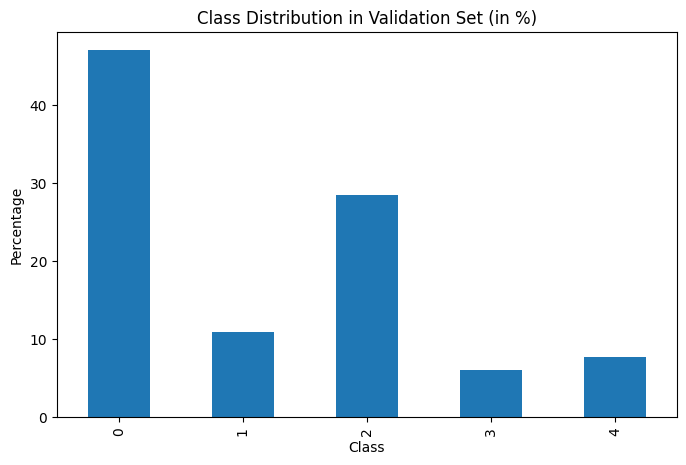

Class Distribution in Validation Set (in %):
diagnosis
0    46.99
2    28.42
1    10.93
4     7.65
3     6.01
Name: proportion, dtype: float64



In [8]:
# Function to calculate and display class distributions
def print_class_distributions(df, dataset_name):
    """Print and plot class distributions in the dataset."""
    class_counts = df['diagnosis'].value_counts(normalize=True) * 100
    class_counts.sort_index().plot(
        kind='bar', title=f'Class Distribution in {dataset_name} (in %)', figsize=(8, 5)
    )
    plt.xlabel("Class")
    plt.ylabel("Percentage")
    plt.show()
    print(f"Class Distribution in {dataset_name} (in %):\n{class_counts.round(2)}\n")

# Plot class distributions for train and validation datasets
print_class_distributions(train_df, "Training Set")
print_class_distributions(valid_df, "Validation Set")

In [9]:
# Data Leakage Check

# Ensure there are no overlaps between training and validation IDs
train_ids = set(train_df['id_code'])
valid_ids = set(valid_df['id_code'])

# Check for overlaps
assert len(train_ids.intersection(valid_ids)) == 0, "Overlap detected between training and validation sets!"
print("No overlap between training and validation sets. Split integrity confirmed!")

No overlap between training and validation sets. Split integrity confirmed!


In [10]:
# Unified directory for all images
ALL_IMAGES_DIR = '/content/data/all_images'

# Create directory if it doesn't exist and copy images
!mkdir -p {ALL_IMAGES_DIR}
!cp {TRAIN_IMAGES_DIR}/*.png {ALL_IMAGES_DIR}
!cp {VAL_IMAGES_DIR}/*.png {ALL_IMAGES_DIR}

In [11]:
from sklearn.model_selection import StratifiedKFold

# Stratified K-Folds

# Combine training and validation datasets
train_full_df = pd.concat([train_df, valid_df], ignore_index=True)
print(f"Combined train+valid shape: {train_full_df.shape}")

# Define number of folds
N_FOLDS = 5

# Perform stratified K-Fold split
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
y = train_full_df['diagnosis'].values

folds = []
for train_index, val_index in skf.split(train_full_df, y):
    fold_train_df = train_full_df.iloc[train_index].reset_index(drop=True)
    fold_val_df = train_full_df.iloc[val_index].reset_index(drop=True)
    folds.append((fold_train_df, fold_val_df))

print(f"Created {N_FOLDS} folds.")

Combined train+valid shape: (3296, 2)
Created 5 folds.


In [12]:
# Validate Fold Integrity

# Ensure no overlaps and consistency in folds
total_samples = 0
for fold_train_df, fold_val_df in folds:
    # Check for overlaps
    assert not fold_train_df['id_code'].isin(fold_val_df['id_code']).any(), "Overlap found between train and val sets"
    # Count validation samples
    total_samples += fold_val_df.shape[0]

# Verify total sample count
assert total_samples == train_full_df.shape[0], "Mismatch in the total number of samples"
print("Fold integrity validated. All folds are consistent and non-overlapping.")

Fold integrity validated. All folds are consistent and non-overlapping.


### Image Visualization and Preprocessing

- Visualized sample retinal images from the training set.
- Applied preprocessing techniques, including resizing, cropping uninformative areas, and enhancing image clarity using Gaussian blurring (based on Ben Graham's method).
- Compared original images with preprocessed versions to highlight improvements and better prepare the data for model training.


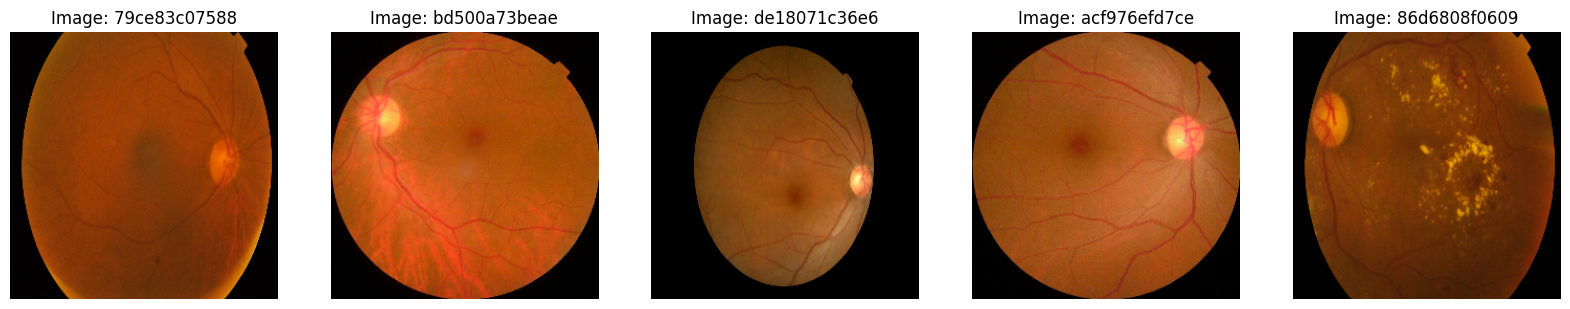

In [13]:
# Example preprocessing function
def preprocess_image(image_path, size=(256, 256)):
    """
    Preprocesses an image by resizing it to the specified size.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)  # Resize to specified size
    return image


# Preprocess and visualize sample images in one row
def visualize_images(image_paths, image_titles):
    plt.figure(figsize=(20, 5))
    for idx, (img_path, title) in enumerate(zip(image_paths, image_titles)):
        img = preprocess_image(img_path)
        plt.subplot(1, len(image_paths), idx + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")
    plt.show()

# Get random sample of 5 images
sample_images = train_df['id_code'].sample(5).values
sample_paths = [f"{TRAIN_IMAGES_DIR}{img_name}.png" for img_name in sample_images]
sample_titles = [f"Image: {img_name}" for img_name in sample_images]

# Visualize images
visualize_images(sample_paths, sample_titles)

In [14]:
# from (https://www.kaggle.com/code/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy)

# Function to crop uninformative borders from the image
def crop_image_from_gray(img, tol=7):
    """
    Crop out black borders or uninformative parts from an image.
    """
    if img.ndim == 2:  # For grayscale images
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:  # For color images
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        if mask.any():
            return img[np.ix_(mask.any(1), mask.any(0))]
    return img  # Return original image if too dark

# Function to apply Ben Graham's preprocessing technique
def load_ben_color(path, img_size=256, sigmaX=10):
    """
    Apply Ben Graham's preprocessing to an input image.
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (img_size, img_size))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
    return image

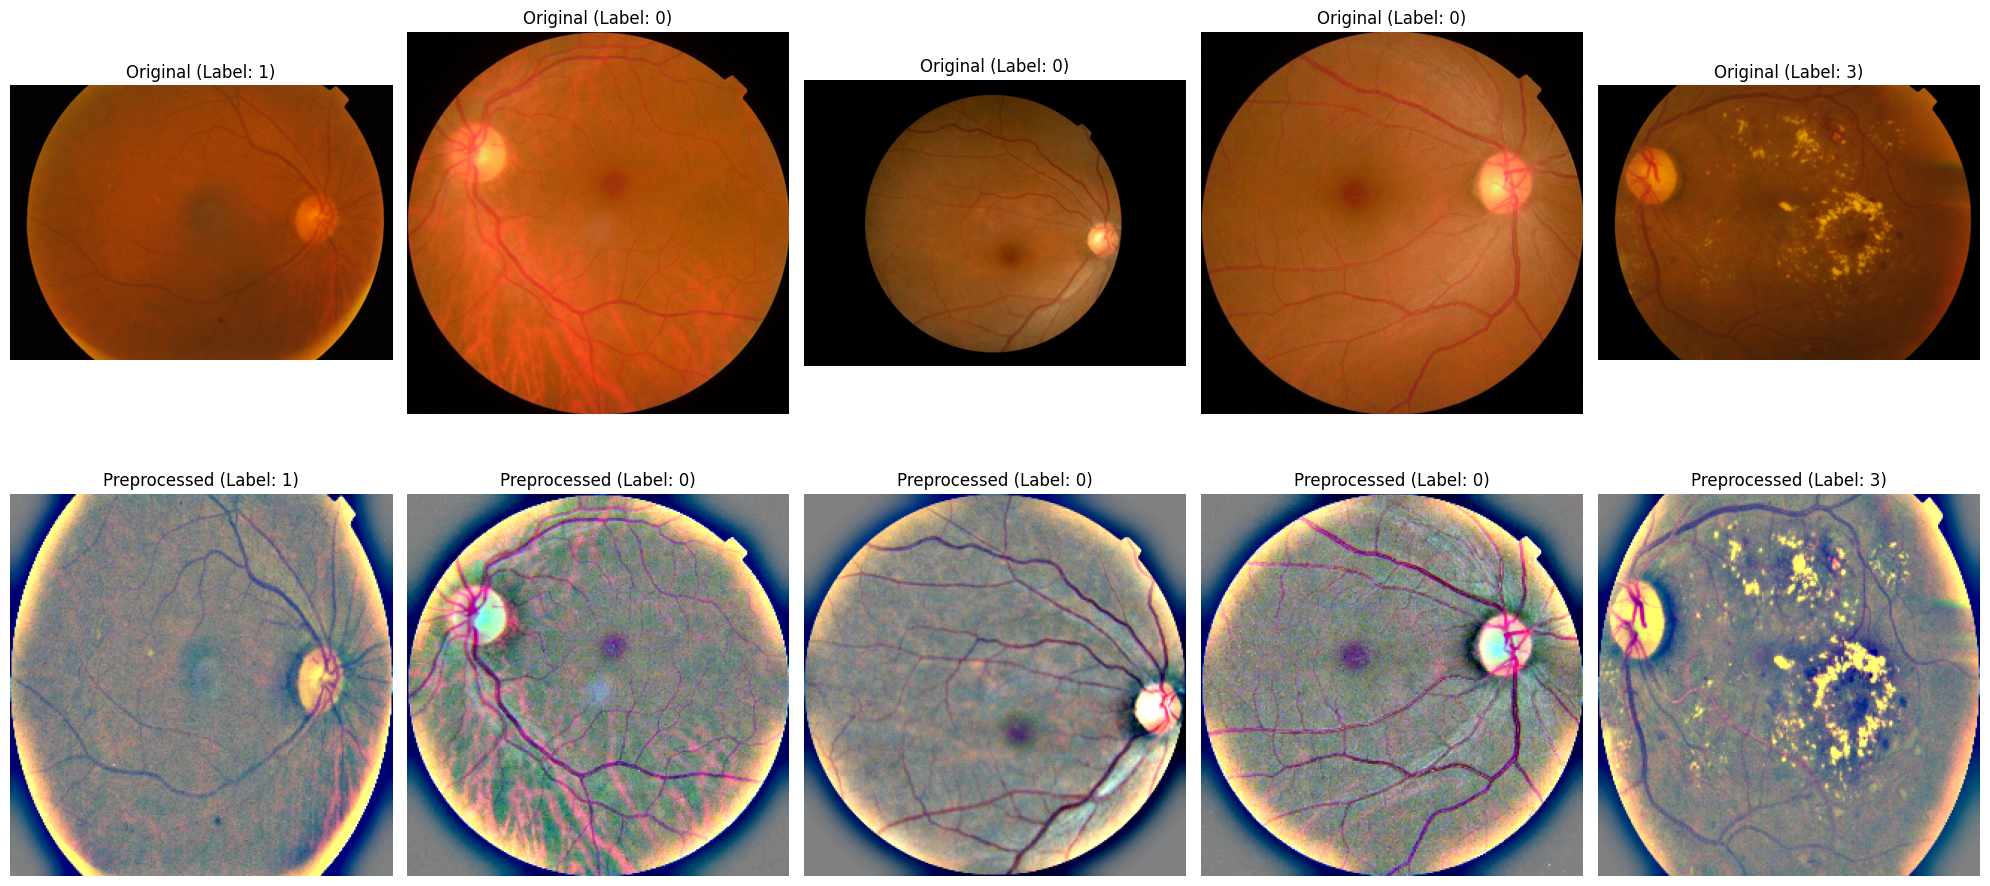

In [15]:
# Visualize images before and after preprocessing
def visualize_preprocessed_images(df, image_dir, sample_size=5, img_size=256):
    """
    Visualize original and preprocessed images side by side for a random sample.
    """
    fig, axs = plt.subplots(2, sample_size, figsize=(20, 10))
    sample = df.sample(sample_size, random_state=42)

    for count, (_, row) in enumerate(sample.iterrows()):
        img_path = os.path.join(image_dir, f"{row['id_code']}.png")

        # Load original image
        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

        # Apply preprocessing
        img_preprocessed = load_ben_color(img_path, img_size=img_size)

        # Plot original image
        axs[0, count].imshow(img_original)
        axs[0, count].set_title(f"Original (Label: {row['diagnosis']})")
        axs[0, count].axis('off')

        # Plot preprocessed image
        axs[1, count].imshow(img_preprocessed)
        axs[1, count].set_title(f"Preprocessed (Label: {row['diagnosis']})")
        axs[1, count].axis('off')

    plt.tight_layout()
    plt.show()


# Visualize a random sample of images
visualize_preprocessed_images(train_df, TRAIN_IMAGES_DIR)

### Dataset Preparation and Model Definition

In this section, I:

- Defined minimal data augmentation techniques using Albumentations for training and validation, including only rotations, flips, and normalization, to avoid conflicting with the Ben Graham preprocessing defined earlier.
- Created a custom dataset class (`APTOSDataset`) to efficiently load and preprocess retinal images.
- Built a custom EfficientNet-based model with the flexibility to:
  - Choose between variants (`b0` or `b4`).
  - Freeze or partially unfreeze the backbone for transfer learning.
  - Customize the classifier head to suit the dataset's number of classes.

In [16]:
def get_train_transforms(img_size=256):
    """
    Data augmentation for training images.
    Includes random rotations, flips, scaling, and normalization.
    """
    return A.Compose([
        A.Rotate(limit=15, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=0, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

def get_val_transforms(img_size=256):
    """
    Transformations for validation images.
    Only normalization is applied.
    """
    return A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

In [17]:
class APTOSDataset(Dataset):
    """
    Custom Dataset for loading and preprocessing APTOS 2019 retinal images.
    """
    def __init__(self, images_dir: str, dataset: pd.DataFrame, transforms=None):
        self.images_dir = images_dir
        self.dataset = dataset
        self.transforms = transforms

    def __getitem__(self, idx: int) -> dict:
        # Get image and label
        entry = self.dataset.iloc[idx]
        img_name = entry['id_code']
        img_path = os.path.join(self.images_dir, f"{img_name}.png")
        label = torch.tensor(int(entry['diagnosis'])).long()

        # Load the image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Apply augmentations if provided
        if self.transforms:
            augmented = self.transforms(image=img)
            img = augmented['image']

        return {
            "image": img,
            "label": label
        }

    def __len__(self) -> int:
        return len(self.dataset)

In [18]:
# Define EfficientNet-based model
from torchvision.models import efficientnet_b0, efficientnet_b4, EfficientNet_B0_Weights, EfficientNet_B4_Weights

class EfficientNet(nn.Module):
    """
    Custom EfficientNet model with options for transfer learning and classifier customization.
    """
    def __init__(self, num_classes=5, dropout_rate=0.2, variant="b0", freeze_backbone=True, unfreeze_blocks=0):
        super(EfficientNet, self).__init__()

        # Select EfficientNet variant
        if variant == "b0":
            self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        elif variant == "b4":
            self.backbone = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
        else:
            raise ValueError("Unsupported EfficientNet variant. Choose 'b0' or 'b4'.")

        # Freeze the backbone if specified
        if freeze_backbone:
            for param in self.backbone.features.parameters():
                param.requires_grad = False

        # Optionally unfreeze the last N blocks
        if unfreeze_blocks > 0:
            print(f"Unfreezing the last {unfreeze_blocks} blocks of the EfficientNet backbone...")
            num_blocks = len(self.backbone.features)
            for idx in range(num_blocks - unfreeze_blocks, num_blocks):
                for param in self.backbone.features[idx].parameters():
                    param.requires_grad = True

        # Replace the classifier to match the dataset
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)

### Training Framework: Trainer and Configuration Classes

In this section, I:

- Built a modular `Trainer` class to manage the training process, including:
  - Initializing data loaders, optimizer, scheduler, and loss functions (`CrossEntropy` or `FocalLoss`).
  - Implementing training and validation loops with metrics such as loss, balanced accuracy, quadratic kappa, and accuracy.
  - Saving the best model for each fold to `.pth` files based on validation performance.
  - Storing metrics (e.g., loss, accuracy) for each fold to enable analysis and reproducibility.
- Designed a `Config` class to centralize hyperparameters and settings, such as:
  - Dataset and model configurations (batch size, learning rate, image size, etc.).
  - Scheduler options (`CosineAnnealing` or `ReduceLROnPlateau`) for dynamic learning rate adjustment.
  - Fine-tuning controls for EfficientNet, such as freezing or unfreezing backbone blocks.

This framework simplifies training, ensures reproducibility, and supports scalability for various deep learning experiments.




In [19]:
class Trainer:
    """
    Trainer class to manage the training and validation of a model.
    Includes data loading, optimizer and scheduler initialization, and metric computation.
    """
    def __init__(self, train_df, val_df, train_path, val_path, cfg, model, class_weights=None):
        self.train_df = train_df
        self.val_df = val_df
        self.train_path = train_path
        self.val_path = val_path
        self.cfg = cfg
        self.model = model.to(cfg.device)
        self.class_weights = class_weights

        # Initialize attributes for tracking metrics
        self.best_score = -float('inf')  # Best Balanced Accuracy (BACC)
        self.best_kappa = -float('inf')  # Best Kappa
        self.best_accuracy = -float('inf')  # Best Accuracy

        self.train_losses, self.val_losses, self.val_baccs = [], [], []
        self.val_kappas, self.val_accuracies = [], []  # Lists for Kappa and Accuracy
        self.val_preds, self.val_labels = [], []

        # Initialize loaders, optimizer, scheduler, and loss function
        self.init_loaders()
        self.init_optimizer_loss()

    def init_loaders(self):
        """Initialize data loaders for training and validation."""
        self.train_loader = DataLoader(
            APTOSDataset(self.train_path, self.train_df, get_train_transforms(self.cfg.image_size)),
            batch_size=self.cfg.batch_size, shuffle=True,
            num_workers=self.cfg.num_workers, drop_last=True
        )

        self.val_loader = DataLoader(
            APTOSDataset(self.val_path, self.val_df, get_val_transforms(self.cfg.image_size)),
            batch_size=self.cfg.batch_size, shuffle=False,
            num_workers=self.cfg.num_workers
        )

    def init_optimizer_loss(self):
        """Initialize optimizer, scheduler, and loss function."""
        backbone_params = [p for p in self.model.backbone.features.parameters() if p.requires_grad]
        classifier_params = [p for p in self.model.backbone.classifier.parameters()]

        self.optimizer = optim.Adam([
            {'params': backbone_params, 'lr': self.cfg.backbone_learning_rate},
            {'params': classifier_params, 'lr': self.cfg.learning_rate}
        ], weight_decay=self.cfg.weight_decay)

        self.scheduler_obj = None
        if self.cfg.scheduler == 'cosine':
            self.scheduler_obj = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=self.cfg.num_epochs)
        elif self.cfg.scheduler == 'plateau':
            self.scheduler_obj = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=self.cfg.lr_patience, factor=self.cfg.lr_factor)

        # Loss function selection: FocalLoss or CrossEntropyLoss
        if self.cfg.use_focal_loss:
            # Check explicitly if class_weights is None
            if self.class_weights is not None:
                self.loss_fn = FocalLoss(alpha=self.class_weights, gamma=2)
            else:
                self.loss_fn = FocalLoss(gamma=2)
        else:
            self.loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)

    def train_epoch(self):
        """Train for one epoch."""
        self.model.train()
        running_loss = 0.0
        for batch in tqdm(self.train_loader, desc=f"Training Epoch {self.epoch}"):
            images, labels = batch['image'].to(self.cfg.device), batch['label'].to(self.cfg.device)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.loss_fn(outputs, labels)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()
        return running_loss / len(self.train_loader)

    def validate_epoch(self):
        """Validate the model and compute metrics."""
        self.model.eval()
        running_loss = 0.0
        all_preds, all_labels = [], []

        # Clear previous predictions and labels
        self.val_preds, self.val_labels = [], []

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validating"):
                images, labels = batch['image'].to(self.cfg.device), batch['label'].to(self.cfg.device)
                outputs = self.model(images)
                loss = self.loss_fn(outputs, labels)
                running_loss += loss.item()

                # Store predictions and labels
                all_preds.append(outputs.cpu().numpy())  # Convert to numpy
                all_labels.append(labels.cpu().numpy())

        avg_loss = running_loss / len(self.val_loader)
        all_preds = np.concatenate(all_preds, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        # Update val_preds and val_labels
        self.val_preds.extend(all_preds)
        self.val_labels.extend(all_labels)

        # Compute metrics
        predicted_classes = all_preds.argmax(axis=1)
        bacc = balanced_accuracy_score(all_labels, predicted_classes)
        kappa = cohen_kappa_score(all_labels, predicted_classes, weights='quadratic')
        accuracy = accuracy_score(all_labels, predicted_classes)

        # Append metrics
        self.val_baccs.append(bacc)
        self.val_kappas.append(kappa)
        self.val_accuracies.append(accuracy)

        return avg_loss, bacc, kappa, accuracy



    def run(self):
        """Run training and validation for all epochs."""

        # Cleanup old files for the current fold only
        results_path = f"{self.cfg.save_dir}/fold_{self.cfg.fold}_results.pth"
        best_model_path = f"{self.cfg.save_dir}/best_model_fold_{self.cfg.fold}.pth"

        if os.path.exists(results_path):
            print(f"Deleting previous results file: {results_path}")
            os.remove(results_path)

        if os.path.exists(best_model_path):
            print(f"Deleting previous best model file: {best_model_path}")
            os.remove(best_model_path)

        # Training loop
        for self.epoch in range(1, self.cfg.num_epochs + 1):
            train_loss = self.train_epoch()
            val_loss, val_bacc, val_kappa, val_accuracy = self.validate_epoch()

            # Append metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            # Save the best model
            if val_bacc > self.best_score:
                self.best_score = val_bacc
                torch.save(self.model.state_dict(), best_model_path)
                print(f"Saved best model for fold {self.cfg.fold} with Balanced Accuracy: {val_bacc:.4f}")

            # Print metrics for the epoch
            print(f"Epoch {self.epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
                  f"Val BAcc={val_bacc:.4f}, Kappa={val_kappa:.4f}, Accuracy={val_accuracy:.4f}")

            # Scheduler step
            if self.scheduler_obj:
                if self.cfg.scheduler == 'plateau':
                    self.scheduler_obj.step(val_loss)
                else:
                    self.scheduler_obj.step()

        # Save results at the end of training for the fold
        results = {
            "train_losses": self.train_losses,
            "val_losses": self.val_losses,
            "val_baccs": self.val_baccs,
            "val_kappas": self.val_kappas,
            "val_accuracies": self.val_accuracies,
        }
        torch.save(results, results_path)
        print(f"Results for fold {self.cfg.fold} saved to {results_path}.")




In [20]:
class Config:
    """
    Unified configuration class to handle all hyperparameters and paths for different experiments.
    """
    def __init__(self):
        # General Settings
        self.batch_size = 32  # Default batch size, can be adjusted per experiment
        self.num_workers = 2  # Number of data loading workers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = 42  # Seed for reproducibility
        self.num_classes = 5  # Number of output classes
        self.image_size = 256  # Default resolution (e.g., EfficientNet-B0), can be adjusted for other variants

        # Model Configuration
        self.model_name = "efficientnet-b0"  # Default model name
        self.variant = "b0"  # Model variant (e.g., "b0", "b4")
        self.freeze_backbone = True  # Whether to freeze the backbone initially
        self.unfreeze_blocks = 0  # Number of blocks to unfreeze during fine-tuning

        # Training Control
        self.num_epochs = 20  # Number of training epochs
        self.learning_rate = 1e-3  # Learning rate for the classifier head
        self.backbone_learning_rate = 1e-5  # Learning rate for the backbone
        self.weight_decay = 1e-4  # Weight decay for regularization

        # Scheduler Configuration
        self.scheduler = 'plateau'  # Options: 'plateau' or 'cosine'
        self.lr_step_size = 5  # For step-based schedulers
        self.lr_gamma = 0.1  # LR reduction factor
        self.lr_patience = 3  # Patience for ReduceLROnPlateau
        self.lr_factor = 0.1  # Factor for ReduceLROnPlateau

        # Loss Function
        self.use_focal_loss = False  # Use FocalLoss if True, otherwise CrossEntropyLoss

        # Fold Information
        self.fold = 0  # Current fold index, updated dynamically during training

        # Save Directory
        self.save_dir = Path("/content/data/snapshots")  # Default save directory
        self.save_dir.mkdir(parents=True, exist_ok=True)



## Efficient Training: Preprocessing and Caching Images (from Lecture 9)

To speed up the training process, I preprocessed and resized all images in advance. Instead of preprocessing images during every epoch, the images are cached in a resized and preprocessed format. This optimization reduces the training epoch time significantly, from approximately 4 minutes to just 5 seconds.

Key steps performed:

- Applied Ben Graham's preprocessing method to all images.
- Resized images to the target size (256x256) and saved them to a new directory (ALL_IMAGES_RESIZED_DIR) for fast retrieval during training.


In [21]:
# Paths for original and resized images
ALL_IMAGES_DIR = '/content/data/all_images'
ALL_IMAGES_RESIZED_DIR = '/content/data/all_images_resized'

# Ensure the resized directory exists
os.makedirs(ALL_IMAGES_RESIZED_DIR, exist_ok=True)

# Get all image file paths
img_paths = glob.glob(os.path.join(ALL_IMAGES_DIR, '*.png'))
img_size = 256  # Target image size

# Resize and preprocess all images
for img_path in tqdm(img_paths, desc="Resizing and Caching Images"):
    # Read and preprocess the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply Ben Graham's preprocessing
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (img_size, img_size))
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 10), -4, 128)

    # Save the preprocessed image to the resized directory
    img_save = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    base_name = os.path.basename(img_path)
    cv2.imwrite(os.path.join(ALL_IMAGES_RESIZED_DIR, base_name), img_save)


Resizing and Caching Images: 100%|██████████| 3296/3296 [09:32<00:00,  5.76it/s]


## Training Loop (Baseline Model)

In this section, I:

- Implemented the `run_cross_validation` function to train and evaluate models across multiple folds:
  - For each fold:
    - Initialized the `Trainer` with fold-specific data splits, dynamically scaled class weights (if provided), and model configurations.
    - Tracked the best balanced accuracy (BACC), quadratic kappa, and accuracy during training.
    - Saved the best-performing model for each fold in `.pth` files.
  - At the end:
    - Computed and displayed the mean and standard deviation of BACC, kappa, and accuracy across folds to summarize performance.

- Used `run_cross_validation` with default configurations to train the baseline model and evaluate its performance.

This process establishes a robust evaluation framework, providing insights into the model's generalization across folds.



In [22]:
def run_cross_validation(cfg, image_dir, custom_scaling_factors=None):
    """
    Runs cross-validation training with specified configuration, image directory, and optional class weights.

    Args:
        cfg (Config): Configuration object containing hyperparameters.
        image_dir (str): Path to the directory containing all images.
        custom_scaling_factors (list, optional): Scaling factors for class weights. If None, no scaling is applied.

    Returns:
        dict: Dictionary containing mean and std for balanced accuracy, kappa, and accuracy across folds.
    """
    # Store results for BACC, Kappa, and Accuracy across folds
    fold_results_bacc = []
    fold_results_kappa = []
    fold_results_acc = []

    for fold_idx, (fold_train_df, fold_val_df) in enumerate(folds):
        cfg.fold = fold_idx  # Set the current fold index
        print(f"Starting Fold {fold_idx + 1}/{len(folds)}...")

        # Calculate class weights if scaling factors are provided
        class_weights = None
        if custom_scaling_factors is not None:
            # Calculate class counts for the training set of this fold
            class_counts = fold_train_df['diagnosis'].value_counts().sort_index().values
            total_samples = sum(class_counts)

            # Compute raw class weights (inverse frequency)
            raw_class_weights = [total_samples / count for count in class_counts]

            # Apply custom scaling factors
            scaled_class_weights = [
                custom_scaling_factors[i] * raw_class_weights[i]
                for i in range(len(raw_class_weights))
            ]

            # Convert to PyTorch tensor and move to device
            class_weights = torch.tensor(scaled_class_weights, dtype=torch.float).to(cfg.device)

        # Initialize model with unfreeze logic from cfg
        model = EfficientNet(
            num_classes=cfg.num_classes,
            variant=cfg.variant,
            freeze_backbone=cfg.freeze_backbone,
            unfreeze_blocks=cfg.unfreeze_blocks
        )

        # Initialize the Trainer
        trainer = Trainer(
            train_df=fold_train_df,
            val_df=fold_val_df,
            train_path=image_dir,  # Single image directory
            val_path=image_dir,  # Use the same directory
            cfg=cfg,
            model=model,
            class_weights=class_weights  # Pass fold-specific scaled weights if available
        )

        # Run the training loop
        trainer.run()

        # Track the best metrics for the current fold
        fold_best_bacc = max(trainer.val_baccs)
        fold_best_kappa = max(trainer.val_kappas)
        fold_best_acc = max(trainer.val_accuracies)

        fold_results_bacc.append(fold_best_bacc)
        fold_results_kappa.append(fold_best_kappa)
        fold_results_acc.append(fold_best_acc)

    # Compute mean and std for each metric
    mean_bacc = np.mean(fold_results_bacc)
    std_bacc = np.std(fold_results_bacc)
    mean_kappa = np.mean(fold_results_kappa)
    std_kappa = np.std(fold_results_kappa)
    mean_acc = np.mean(fold_results_acc)
    std_acc = np.std(fold_results_acc)

    # Print results
    print(f"Mean Balanced Accuracy across {len(folds)} folds: {mean_bacc:.4f} ± {std_bacc:.4f}")
    print(f"Mean Kappa across {len(folds)} folds: {mean_kappa:.4f} ± {std_kappa:.4f}")
    print(f"Mean Accuracy across {len(folds)} folds: {mean_acc:.4f} ± {std_acc:.4f}")

    return {
        "mean_bacc": mean_bacc,
        "std_bacc": std_bacc,
        "mean_kappa": mean_kappa,
        "std_kappa": std_kappa,
        "mean_acc": mean_acc,
        "std_acc": std_acc,
        "trainer": trainer
    }


In [23]:
cfg = Config()  # Initialize default config
results_baseline = run_cross_validation(cfg, ALL_IMAGES_RESIZED_DIR)

Starting Fold 1/5...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 135MB/s] 
Validating: 100%|██████████| 21/21 [00:01<00:00, 14.86it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.3793
Epoch 1: Train Loss=0.9981, Val Loss=0.7863, Val BAcc=0.3793, Kappa=0.6450, Accuracy=0.7152


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.89it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.4513
Epoch 2: Train Loss=0.7901, Val Loss=0.7128, Val BAcc=0.4513, Kappa=0.7383, Accuracy=0.7561


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.88it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.4955
Epoch 3: Train Loss=0.7399, Val Loss=0.6929, Val BAcc=0.4955, Kappa=0.7313, Accuracy=0.7652


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.94it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.4965
Epoch 4: Train Loss=0.6989, Val Loss=0.6571, Val BAcc=0.4965, Kappa=0.7729, Accuracy=0.7712


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.17it/s]


Epoch 5: Train Loss=0.6870, Val Loss=0.6528, Val BAcc=0.4889, Kappa=0.7821, Accuracy=0.7697


Validating: 100%|██████████| 21/21 [00:01<00:00, 15.12it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5193
Epoch 6: Train Loss=0.6684, Val Loss=0.6515, Val BAcc=0.5193, Kappa=0.7727, Accuracy=0.7773


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5215
Epoch 7: Train Loss=0.6549, Val Loss=0.6448, Val BAcc=0.5215, Kappa=0.7831, Accuracy=0.7773


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.73it/s]


Epoch 8: Train Loss=0.6547, Val Loss=0.6566, Val BAcc=0.4967, Kappa=0.7890, Accuracy=0.7742


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.91it/s]


Epoch 9: Train Loss=0.6474, Val Loss=0.6384, Val BAcc=0.5040, Kappa=0.7780, Accuracy=0.7697


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.87it/s]


Epoch 10: Train Loss=0.6235, Val Loss=0.6416, Val BAcc=0.5147, Kappa=0.7852, Accuracy=0.7773


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.99it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5584
Epoch 11: Train Loss=0.6038, Val Loss=0.6417, Val BAcc=0.5584, Kappa=0.8080, Accuracy=0.7773


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.63it/s]


Epoch 12: Train Loss=0.6260, Val Loss=0.6402, Val BAcc=0.5250, Kappa=0.7931, Accuracy=0.7803


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.63it/s]


Epoch 13: Train Loss=0.6235, Val Loss=0.6348, Val BAcc=0.5280, Kappa=0.8196, Accuracy=0.7788


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.62it/s]


Epoch 14: Train Loss=0.6146, Val Loss=0.6369, Val BAcc=0.5311, Kappa=0.8141, Accuracy=0.7909


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.21it/s]


Epoch 15: Train Loss=0.5936, Val Loss=0.6396, Val BAcc=0.5295, Kappa=0.8103, Accuracy=0.7864


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.69it/s]


Epoch 16: Train Loss=0.5970, Val Loss=0.6445, Val BAcc=0.5286, Kappa=0.8092, Accuracy=0.7818


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.57it/s]


Epoch 17: Train Loss=0.5947, Val Loss=0.6343, Val BAcc=0.5416, Kappa=0.8117, Accuracy=0.7833


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.80it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5698
Epoch 18: Train Loss=0.6078, Val Loss=0.6399, Val BAcc=0.5698, Kappa=0.7921, Accuracy=0.7545


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.53it/s]


Epoch 19: Train Loss=0.5984, Val Loss=0.6396, Val BAcc=0.5449, Kappa=0.7800, Accuracy=0.7803


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.15it/s]


Epoch 20: Train Loss=0.5901, Val Loss=0.6297, Val BAcc=0.5458, Kappa=0.8042, Accuracy=0.7712
Results for fold 0 saved to /content/data/snapshots/fold_0_results.pth.
Starting Fold 2/5...


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.55it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.4419
Epoch 1: Train Loss=1.0020, Val Loss=0.7819, Val BAcc=0.4419, Kappa=0.7131, Accuracy=0.7344


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.75it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.4942
Epoch 2: Train Loss=0.7846, Val Loss=0.7279, Val BAcc=0.4942, Kappa=0.7264, Accuracy=0.7390


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.55it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5190
Epoch 3: Train Loss=0.7535, Val Loss=0.6740, Val BAcc=0.5190, Kappa=0.7752, Accuracy=0.7633


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.40it/s]


Epoch 4: Train Loss=0.6995, Val Loss=0.6587, Val BAcc=0.5140, Kappa=0.7591, Accuracy=0.7678


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.50it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5408
Epoch 5: Train Loss=0.6924, Val Loss=0.6383, Val BAcc=0.5408, Kappa=0.7880, Accuracy=0.7678


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.74it/s]


Epoch 6: Train Loss=0.6695, Val Loss=0.6297, Val BAcc=0.5287, Kappa=0.7738, Accuracy=0.7602


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.61it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5506
Epoch 7: Train Loss=0.6418, Val Loss=0.6452, Val BAcc=0.5506, Kappa=0.7746, Accuracy=0.7693


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.59it/s]


Epoch 8: Train Loss=0.6527, Val Loss=0.6127, Val BAcc=0.5226, Kappa=0.8160, Accuracy=0.7724


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.64it/s]


Epoch 9: Train Loss=0.6352, Val Loss=0.6244, Val BAcc=0.5245, Kappa=0.7934, Accuracy=0.7633


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.31it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5655
Epoch 10: Train Loss=0.6365, Val Loss=0.6106, Val BAcc=0.5655, Kappa=0.8248, Accuracy=0.7754


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.73it/s]


Epoch 11: Train Loss=0.6152, Val Loss=0.6272, Val BAcc=0.5423, Kappa=0.8032, Accuracy=0.7739


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5719
Epoch 12: Train Loss=0.6253, Val Loss=0.6139, Val BAcc=0.5719, Kappa=0.8165, Accuracy=0.7754


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 13: Train Loss=0.6102, Val Loss=0.6040, Val BAcc=0.5665, Kappa=0.8182, Accuracy=0.7724


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5835
Epoch 14: Train Loss=0.6099, Val Loss=0.6159, Val BAcc=0.5835, Kappa=0.8237, Accuracy=0.7724


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.88it/s]


Epoch 15: Train Loss=0.6104, Val Loss=0.6063, Val BAcc=0.5787, Kappa=0.8281, Accuracy=0.7830


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.57it/s]


Epoch 16: Train Loss=0.6094, Val Loss=0.6092, Val BAcc=0.5511, Kappa=0.8202, Accuracy=0.7754


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Epoch 17: Train Loss=0.5994, Val Loss=0.6130, Val BAcc=0.5734, Kappa=0.8242, Accuracy=0.7769


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.62it/s]


Epoch 18: Train Loss=0.5902, Val Loss=0.6088, Val BAcc=0.5695, Kappa=0.8197, Accuracy=0.7830


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.61it/s]


Epoch 19: Train Loss=0.5821, Val Loss=0.6137, Val BAcc=0.5718, Kappa=0.8156, Accuracy=0.7785


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.91it/s]


Epoch 20: Train Loss=0.5957, Val Loss=0.5995, Val BAcc=0.5771, Kappa=0.8394, Accuracy=0.7891
Results for fold 1 saved to /content/data/snapshots/fold_1_results.pth.
Starting Fold 3/5...


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.82it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.4214
Epoch 1: Train Loss=0.9857, Val Loss=0.7695, Val BAcc=0.4214, Kappa=0.7184, Accuracy=0.7269


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.18it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.4564
Epoch 2: Train Loss=0.7801, Val Loss=0.7016, Val BAcc=0.4564, Kappa=0.7618, Accuracy=0.7360


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.29it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5100
Epoch 3: Train Loss=0.7331, Val Loss=0.6931, Val BAcc=0.5100, Kappa=0.7742, Accuracy=0.7269


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.61it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5390
Epoch 4: Train Loss=0.7016, Val Loss=0.6604, Val BAcc=0.5390, Kappa=0.7765, Accuracy=0.7572


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.33it/s]


Epoch 5: Train Loss=0.6700, Val Loss=0.6415, Val BAcc=0.5173, Kappa=0.7721, Accuracy=0.7572


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Epoch 6: Train Loss=0.6625, Val Loss=0.6301, Val BAcc=0.4849, Kappa=0.7919, Accuracy=0.7602


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.91it/s]


Epoch 7: Train Loss=0.6518, Val Loss=0.6233, Val BAcc=0.4902, Kappa=0.7807, Accuracy=0.7587


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.46it/s]


Epoch 8: Train Loss=0.6458, Val Loss=0.6250, Val BAcc=0.5113, Kappa=0.7936, Accuracy=0.7633


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.46it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5595
Epoch 9: Train Loss=0.6440, Val Loss=0.6179, Val BAcc=0.5595, Kappa=0.8238, Accuracy=0.7693


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.53it/s]


Epoch 10: Train Loss=0.6300, Val Loss=0.6173, Val BAcc=0.5139, Kappa=0.8128, Accuracy=0.7693


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.12it/s]


Epoch 11: Train Loss=0.6136, Val Loss=0.6135, Val BAcc=0.5267, Kappa=0.8130, Accuracy=0.7678


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5598
Epoch 12: Train Loss=0.6282, Val Loss=0.6089, Val BAcc=0.5598, Kappa=0.8351, Accuracy=0.7785


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.39it/s]


Epoch 13: Train Loss=0.6212, Val Loss=0.6084, Val BAcc=0.5551, Kappa=0.8128, Accuracy=0.7769


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.51it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5670
Epoch 14: Train Loss=0.6054, Val Loss=0.5952, Val BAcc=0.5670, Kappa=0.8429, Accuracy=0.7860


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.51it/s]


Epoch 15: Train Loss=0.6114, Val Loss=0.5990, Val BAcc=0.5288, Kappa=0.8190, Accuracy=0.7800


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.70it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5686
Epoch 16: Train Loss=0.5918, Val Loss=0.5948, Val BAcc=0.5686, Kappa=0.8389, Accuracy=0.7845


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.51it/s]


Epoch 17: Train Loss=0.5909, Val Loss=0.5865, Val BAcc=0.5473, Kappa=0.8386, Accuracy=0.7800


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.13it/s]


Epoch 18: Train Loss=0.5955, Val Loss=0.5887, Val BAcc=0.5521, Kappa=0.8543, Accuracy=0.7876


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.57it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5782
Epoch 19: Train Loss=0.5935, Val Loss=0.5989, Val BAcc=0.5782, Kappa=0.8204, Accuracy=0.7860


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.59it/s]


Epoch 20: Train Loss=0.5943, Val Loss=0.5984, Val BAcc=0.5495, Kappa=0.8499, Accuracy=0.7845
Results for fold 2 saved to /content/data/snapshots/fold_2_results.pth.
Starting Fold 4/5...


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.43it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.3824
Epoch 1: Train Loss=0.9883, Val Loss=0.7933, Val BAcc=0.3824, Kappa=0.6861, Accuracy=0.7147


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.74it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.4455
Epoch 2: Train Loss=0.7894, Val Loss=0.7134, Val BAcc=0.4455, Kappa=0.7352, Accuracy=0.7375


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.42it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.4635
Epoch 3: Train Loss=0.7289, Val Loss=0.6947, Val BAcc=0.4635, Kappa=0.7480, Accuracy=0.7496


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.69it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.5109
Epoch 4: Train Loss=0.7057, Val Loss=0.6737, Val BAcc=0.5109, Kappa=0.7716, Accuracy=0.7587


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.50it/s]


Epoch 5: Train Loss=0.6750, Val Loss=0.6439, Val BAcc=0.5102, Kappa=0.7733, Accuracy=0.7693


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.40it/s]


Epoch 6: Train Loss=0.6781, Val Loss=0.6578, Val BAcc=0.4779, Kappa=0.7606, Accuracy=0.7557


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.48it/s]


Epoch 7: Train Loss=0.6527, Val Loss=0.6439, Val BAcc=0.4774, Kappa=0.7707, Accuracy=0.7587


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.38it/s]


Epoch 8: Train Loss=0.6476, Val Loss=0.6336, Val BAcc=0.4844, Kappa=0.7982, Accuracy=0.7663


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.68it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.5316
Epoch 9: Train Loss=0.6355, Val Loss=0.6352, Val BAcc=0.5316, Kappa=0.7851, Accuracy=0.7648


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.42it/s]


Epoch 10: Train Loss=0.6453, Val Loss=0.6259, Val BAcc=0.5090, Kappa=0.8005, Accuracy=0.7739


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.80it/s]


Epoch 11: Train Loss=0.6276, Val Loss=0.6400, Val BAcc=0.4953, Kappa=0.7730, Accuracy=0.7678


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Epoch 12: Train Loss=0.6175, Val Loss=0.6162, Val BAcc=0.5099, Kappa=0.8001, Accuracy=0.7663


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.13it/s]


Epoch 13: Train Loss=0.6193, Val Loss=0.6216, Val BAcc=0.5240, Kappa=0.8023, Accuracy=0.7618


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.74it/s]


Epoch 14: Train Loss=0.6091, Val Loss=0.6199, Val BAcc=0.5062, Kappa=0.8015, Accuracy=0.7648


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.38it/s]


Epoch 15: Train Loss=0.5996, Val Loss=0.6235, Val BAcc=0.4987, Kappa=0.8179, Accuracy=0.7754


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.51it/s]


Epoch 16: Train Loss=0.6228, Val Loss=0.6109, Val BAcc=0.5276, Kappa=0.8156, Accuracy=0.7678


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.62it/s]


Epoch 17: Train Loss=0.5971, Val Loss=0.6211, Val BAcc=0.5225, Kappa=0.8034, Accuracy=0.7633


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.05it/s]


Epoch 18: Train Loss=0.6007, Val Loss=0.6024, Val BAcc=0.5309, Kappa=0.8206, Accuracy=0.7739


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.50it/s]


Epoch 19: Train Loss=0.5924, Val Loss=0.6245, Val BAcc=0.5122, Kappa=0.8111, Accuracy=0.7724


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.42it/s]


Epoch 20: Train Loss=0.5814, Val Loss=0.6202, Val BAcc=0.5290, Kappa=0.8253, Accuracy=0.7739
Results for fold 3 saved to /content/data/snapshots/fold_3_results.pth.
Starting Fold 5/5...


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.74it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.4072
Epoch 1: Train Loss=0.9953, Val Loss=0.7919, Val BAcc=0.4072, Kappa=0.6414, Accuracy=0.7041


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.58it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.4807
Epoch 2: Train Loss=0.7829, Val Loss=0.6969, Val BAcc=0.4807, Kappa=0.7455, Accuracy=0.7527


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.46it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.5125
Epoch 3: Train Loss=0.7408, Val Loss=0.6548, Val BAcc=0.5125, Kappa=0.7604, Accuracy=0.7572


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 4: Train Loss=0.7129, Val Loss=0.6269, Val BAcc=0.5056, Kappa=0.7743, Accuracy=0.7618


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.5144
Epoch 5: Train Loss=0.6962, Val Loss=0.6162, Val BAcc=0.5144, Kappa=0.7958, Accuracy=0.7754


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.75it/s]


Epoch 6: Train Loss=0.6732, Val Loss=0.6113, Val BAcc=0.4707, Kappa=0.7915, Accuracy=0.7709


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.60it/s]


Epoch 7: Train Loss=0.6623, Val Loss=0.5972, Val BAcc=0.5078, Kappa=0.7993, Accuracy=0.7739


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.23it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.5299
Epoch 8: Train Loss=0.6769, Val Loss=0.5802, Val BAcc=0.5299, Kappa=0.8010, Accuracy=0.7724


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.54it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.5618
Epoch 9: Train Loss=0.6556, Val Loss=0.5774, Val BAcc=0.5618, Kappa=0.8133, Accuracy=0.7785


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.60it/s]


Epoch 10: Train Loss=0.6303, Val Loss=0.5687, Val BAcc=0.5491, Kappa=0.8305, Accuracy=0.7921


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 11: Train Loss=0.6470, Val Loss=0.5600, Val BAcc=0.5613, Kappa=0.8205, Accuracy=0.7860


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.58it/s]


Epoch 12: Train Loss=0.6186, Val Loss=0.5850, Val BAcc=0.4988, Kappa=0.7964, Accuracy=0.7709


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.52it/s]


Epoch 13: Train Loss=0.6123, Val Loss=0.5794, Val BAcc=0.5594, Kappa=0.8322, Accuracy=0.7906


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.61it/s]


Epoch 14: Train Loss=0.6155, Val Loss=0.5630, Val BAcc=0.5533, Kappa=0.8335, Accuracy=0.7876


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.50it/s]


Epoch 15: Train Loss=0.6310, Val Loss=0.5691, Val BAcc=0.5340, Kappa=0.8277, Accuracy=0.7800


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.68it/s]


Epoch 16: Train Loss=0.5917, Val Loss=0.5706, Val BAcc=0.5502, Kappa=0.8108, Accuracy=0.7845


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.88it/s]


Epoch 17: Train Loss=0.5964, Val Loss=0.5642, Val BAcc=0.5498, Kappa=0.8290, Accuracy=0.7815


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.39it/s]


Epoch 18: Train Loss=0.5912, Val Loss=0.5561, Val BAcc=0.5523, Kappa=0.8220, Accuracy=0.7876


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.64it/s]


Epoch 19: Train Loss=0.5957, Val Loss=0.5524, Val BAcc=0.5548, Kappa=0.8266, Accuracy=0.7845


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]

Epoch 20: Train Loss=0.6074, Val Loss=0.5642, Val BAcc=0.5602, Kappa=0.8253, Accuracy=0.7845
Results for fold 4 saved to /content/data/snapshots/fold_4_results.pth.
Mean Balanced Accuracy across 5 folds: 0.5650 ± 0.0182
Mean Kappa across 5 folds: 0.8344 ± 0.0121
Mean Accuracy across 5 folds: 0.7870 ± 0.0060


### Model Evaluation and Visualization

In this section, I evaluated the baseline model's performance using various metrics and visualizations:

- **Out-of-Fold (OOF) Predictions**:
  - Retrieved predictions and true labels across all folds using the `get_oof_predictions` function.
  - Prepared OOF predictions as a baseline for later comparison with an improved model using a bootstrap hypothesis test.
- **Expected Calibration Error (ECE)**:
  - Computed ECE to measure how well the model's predicted probabilities align with actual outcomes.
- **Performance Analysis**:
  - Evaluated metrics such as balanced accuracy and misclassification percentages per class.
  - Generated a detailed classification report for the validation set.
- **Visualization**:
  - Plotted training and validation trends (loss, balanced accuracy, and kappa) for selected folds.
  - Visualized examples of correct and incorrect predictions.
  - Analyzed misclassification percentages per class using bar plots.

These metrics and visualizations provide a comprehensive understanding of the model’s behavior, calibration, and error distribution. The OOF predictions establish a strong baseline for evaluating improvements in subsequent models.


In [24]:
# Bootstrapping

def get_oof_predictions(cfg, image_dir, folds):
    all_oof_preds = []
    all_oof_labels = []

    for fold_idx, (_, fold_val_df) in enumerate(folds):
        # Set the fold index in cfg so paths align if needed
        cfg.fold = fold_idx
        best_model_path = f"{cfg.save_dir}/best_model_fold_{cfg.fold}.pth"

        # Load the best model for this fold
        model = EfficientNet(
            num_classes=cfg.num_classes,
            variant=cfg.variant,
            freeze_backbone=cfg.freeze_backbone,
            unfreeze_blocks=cfg.unfreeze_blocks
        )
        model.load_state_dict(torch.load(best_model_path, map_location=cfg.device))
        model.to(cfg.device)
        model.eval()

        # Prepare validation loader
        val_loader = DataLoader(
            APTOSDataset(image_dir, fold_val_df, get_val_transforms(cfg.image_size)),
            batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers
        )

        # Get predictions for this fold
        fold_preds = []
        fold_labels = []
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch['image'].to(cfg.device), batch['label'].to(cfg.device)
                outputs = model(images)
                fold_preds.append(outputs.cpu().numpy())
                fold_labels.append(labels.cpu().numpy())

        fold_preds = np.concatenate(fold_preds, axis=0)
        fold_labels = np.concatenate(fold_labels, axis=0)

        all_oof_preds.append(fold_preds)
        all_oof_labels.append(fold_labels)

    # Concatenate across all folds
    all_oof_preds = np.concatenate(all_oof_preds, axis=0)
    all_oof_labels = np.concatenate(all_oof_labels, axis=0)

    return all_oof_preds, all_oof_labels

In [25]:
def bootstrap_test(y_true, preds_model1, preds_model2, n_bootstraps=10000, random_state=42):
    """
    Perform a bootstrap hypothesis test comparing the balanced accuracy of two models.

    Args:
        y_true (np.ndarray): Ground truth labels for all out-of-fold samples.
        preds_model1 (np.ndarray): OOF predictions for model 1 (e.g., baseline).
                                   Shape: (N, num_classes).
                                   Predictions are raw logits or probabilities.
        preds_model2 (np.ndarray): OOF predictions for model 2 (e.g., improved model).
                                   Shape: (N, num_classes).
        n_bootstraps (int): Number of bootstrap resamples to perform.
        random_state (int): Random seed for reproducibility.

    Returns:
        p_value (float): The p-value from the bootstrap test.
        differences (np.ndarray): Array of all bootstrap differences (improved - baseline).
    """
    rng = np.random.default_rng(random_state)

    # Convert predictions to classes
    model1_classes = preds_model1.argmax(axis=1)
    model2_classes = preds_model2.argmax(axis=1)

    N = len(y_true)
    differences = []

    # Perform bootstrap sampling
    for _ in range(n_bootstraps):
        indices = rng.integers(0, N, size=N)
        bacc1 = balanced_accuracy_score(y_true[indices], model1_classes[indices])
        bacc2 = balanced_accuracy_score(y_true[indices], model2_classes[indices])
        differences.append(bacc2 - bacc1)

    differences = np.array(differences)
    # p-value: proportion of bootstrap differences that are <= 0
    # (i.e., how often improved model is not better than baseline)
    p_value = np.mean(differences <= 0)

    return p_value, differences


In [26]:
baseline_oof_preds, baseline_oof_labels = get_oof_predictions(cfg, ALL_IMAGES_RESIZED_DIR, folds)

<ipython-input-24-4f4db3afa07a>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=cfg.device))


In [27]:
def compute_ece(logits, labels, n_bins=10):
    from scipy.special import softmax
    probs = softmax(logits, axis=1)
    predicted_classes = probs.argmax(axis=1)
    correct = (predicted_classes == labels)
    confidences = probs[np.arange(len(probs)), predicted_classes]

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_indices = np.digitize(confidences, bins) - 1

    ece = 0.0
    N = len(probs)
    for b in range(n_bins):
        in_bin = (bin_indices == b)
        bin_count = np.sum(in_bin)
        if bin_count > 0:
            bin_acc = np.mean(correct[in_bin])
            bin_conf = np.mean(confidences[in_bin])
            ece += (bin_count / N) * np.abs(bin_conf - bin_acc)
    return ece

In [28]:
# After training is done for a fold
final_preds = np.array(results_baseline['trainer'].val_preds)
final_labels = np.array(results_baseline['trainer'].val_labels)

In [29]:
def visualize_fold_results(fold_index):
    """
    Visualize training and validation metrics for a given fold.
    """
    # Fixed path to the results directory
    results_dir = "/content/data/snapshots"
    results_file = os.path.join(results_dir, f"fold_{fold_index}_results.pth")

    # Check if the results file exists
    if not os.path.exists(results_file):
        print(f"No results file found for fold {fold_index}.")
        return

    print(f"Loading results file for fold {fold_index} from {results_file}.")
    results = torch.load(results_file, weights_only=False)

    # Extract metrics
    train_losses = results["train_losses"]
    val_losses = results["val_losses"]
    val_baccs = results["val_baccs"]
    val_kappas = results["val_kappas"]
    val_accuracies = results["val_accuracies"]

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss (Fold {fold_index})')
    plt.legend()
    plt.show()

    # Plot validation metrics (Balanced Accuracy, Kappa, Accuracy)
    plt.figure(figsize=(10, 5))
    plt.plot(val_baccs, label='Balanced Accuracy')
    plt.plot(val_kappas, label='Kappa')
    plt.plot(val_accuracies, label='Accuracy')
    plt.axhline(0.5, color='red', linestyle='--', label='Random Baseline (0.5)')
    plt.ylim(0, 1)  # Set Y-axis range from 0 to 1
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.title(f'Validation Metrics (Fold {fold_index})')
    plt.legend()
    plt.show()

Loading results file for fold 2 from /content/data/snapshots/fold_2_results.pth.


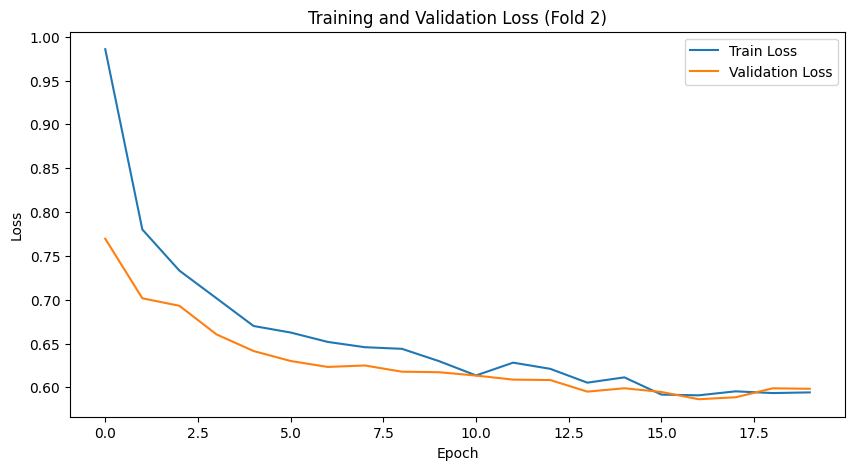

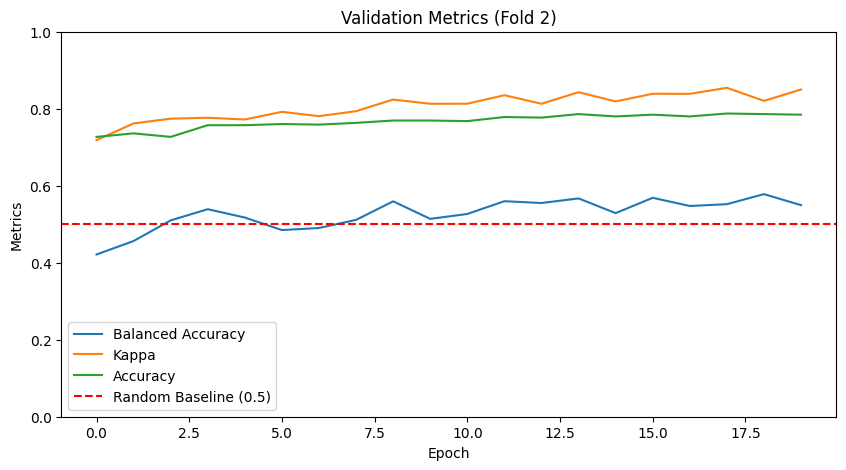

In [30]:
# Visualize metrics for a specific fold
visualize_fold_results(fold_index=2)

In [31]:
def visualize_predictions(val_df, val_preds, val_labels, images_dir, num_samples=5):
    """
    Visualize some examples of correct and incorrect predictions.

    Args:
        val_df (pd.DataFrame): Validation dataframe with 'id_code' and 'diagnosis' columns.
        val_preds (np.ndarray): Model predictions (after argmax) or logits for the final epoch.
        val_labels (np.ndarray): Ground truth labels for the final epoch.
        images_dir (str): Directory containing the validation images.
        num_samples (int): Number of samples to visualize for correct and incorrect predictions.
    """
    # If val_preds are logits/probs, get predicted classes
    predicted_classes = val_preds.argmax(axis=1) if val_preds.ndim > 1 else val_preds

    # Identify correct and incorrect samples
    correct_indices = np.where(predicted_classes == val_labels)[0]
    incorrect_indices = np.where(predicted_classes != val_labels)[0]

    # Randomly select samples
    correct_samples = np.random.choice(correct_indices, size=min(num_samples, len(correct_indices)), replace=False) \
                      if len(correct_indices) > 0 else []
    incorrect_samples = np.random.choice(incorrect_indices, size=min(num_samples, len(incorrect_indices)), replace=False) \
                        if len(incorrect_indices) > 0 else []

    def plot_samples(indices, title):
        if len(indices) == 0:
            print(f"No {title.lower()} samples to show.")
            return
        plt.figure(figsize=(20, 5))
        for i, idx in enumerate(indices):
            entry = val_df.iloc[idx]
            img_name = entry['id_code']
            img_path = os.path.join(images_dir, f"{img_name}.png")

            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            true_label = val_labels[idx]
            pred_label = predicted_classes[idx]

            plt.subplot(1, len(indices), i+1)
            plt.imshow(img)
            plt.title(f"Pred: {pred_label}, True: {true_label}", fontsize=12)
            plt.axis('off')
        plt.suptitle(title, fontsize=16)
        plt.show()

    # Plot correct predictions
    plot_samples(correct_samples, "Correct Predictions")

    # Plot incorrect predictions
    plot_samples(incorrect_samples, "Incorrect Predictions")


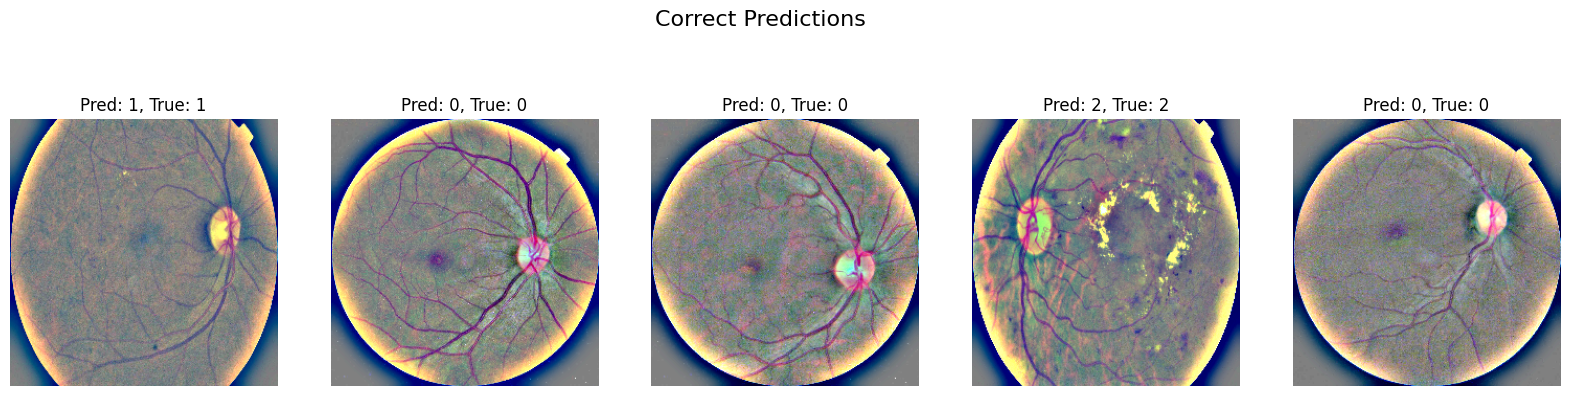

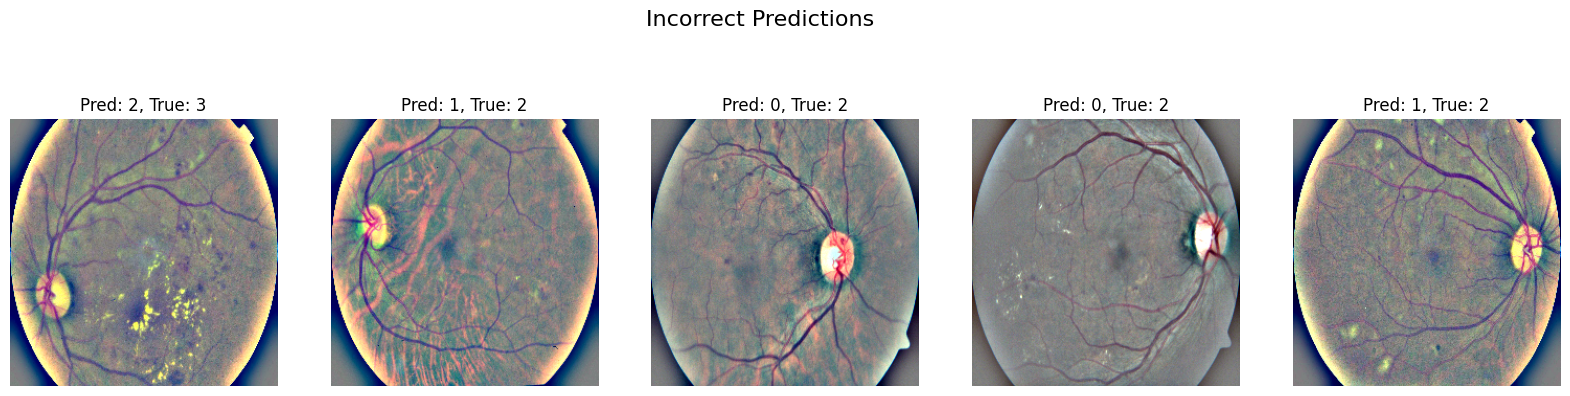

In [32]:
# Visualize correct and incorrect predictions
visualize_predictions(results_baseline['trainer'].val_df, final_preds, final_labels, ALL_IMAGES_RESIZED_DIR, num_samples=5)

In [33]:
def plot_misclassification_percentages(final_preds, final_labels):
    # Convert predictions to class indices if necessary
    predicted_classes = final_preds.argmax(axis=1) if final_preds.ndim > 1 else final_preds

    # Identify indices of incorrect predictions
    incorrect_indices = np.where(predicted_classes != final_labels)[0]

    # Extract the true labels of the incorrect samples
    incorrect_true_labels = final_labels[incorrect_indices]

    # Count occurrences of incorrect predictions per class
    unique_classes, incorrect_counts = np.unique(incorrect_true_labels, return_counts=True)

    # Count total samples per class in the validation set
    total_unique, total_counts = np.unique(final_labels, return_counts=True)
    class_counts_dict = dict(zip(total_unique, total_counts))

    # Convert misclassification counts to percentages
    percentages = {
        unique_classes[i]: (incorrect_counts[i] / class_counts_dict[unique_classes[i]]) * 100
        for i in range(len(unique_classes))
    }

    # Plot the percentage of misclassifications per class
    plt.figure(figsize=(8, 5))
    plt.bar(percentages.keys(), percentages.values())
    plt.ylim(0, 100)
    plt.xlabel('Class')
    plt.ylabel('Percentage of Class Misclassified (%)')
    plt.title('Percentage of Each Class Misclassified')
    plt.xticks(list(class_counts_dict.keys()))  # Ensure all class labels are displayed
    plt.show()

    return percentages


In [34]:
def evaluate_predictions(final_preds, final_labels, n_bins=10):
    """
    Evaluate model predictions using Expected Calibration Error (ECE),
    misclassification percentages, and a classification report.

    Args:
        final_preds (np.ndarray): Predicted probabilities or logits from the model.
        final_labels (np.ndarray): Ground truth labels.
        n_bins (int, optional): Number of bins for ECE computation. Default is 10.

    Returns:
        dict: A dictionary containing ECE, misclassification percentages, and the classification report.
    """
    # Compute Expected Calibration Error (ECE)
    ece = compute_ece(final_preds, final_labels, n_bins=n_bins)
    print(f"Expected Calibration Error (ECE): {ece:.4f}")

    # Analyze misclassification percentages
    percentages = plot_misclassification_percentages(final_preds, final_labels)
    print("Misclassification percentages per class:")
    for cls, pct in percentages.items():
        print(f"Class {cls}: {pct:.2f}%")

    # Print classification report
    classification_report_text = classification_report(final_labels, final_preds.argmax(axis=1), digits=2)
    print("\nClassification Report:\n", classification_report_text)

    # Return results as a dictionary
    return {
        "ece": ece,
        "misclassification_percentages": percentages,
        "classification_report": classification_report_text
    }


Expected Calibration Error (ECE): 0.0293


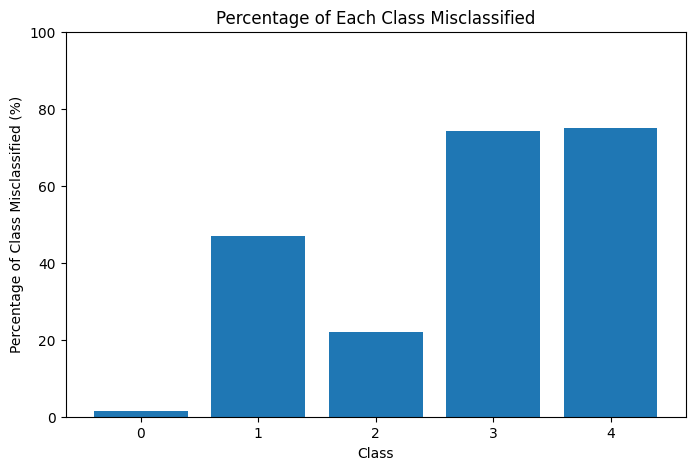

Misclassification percentages per class:
Class 0: 1.55%
Class 1: 47.06%
Class 2: 21.98%
Class 3: 74.29%
Class 4: 75.00%

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       322
           1       0.55      0.53      0.54        68
           2       0.68      0.78      0.72       182
           3       0.45      0.26      0.33        35
           4       0.65      0.25      0.36        52

    accuracy                           0.78       659
   macro avg       0.65      0.56      0.58       659
weighted avg       0.77      0.78      0.77       659



In [35]:
# Evaluate predictions
evaluation_results = evaluate_predictions(final_preds, final_labels)

### Model Evaluation and Visualization

In this section, I evaluated the baseline model's performance and identified the following key points:

- **High Misclassification for Class 1**: The model struggles to distinguish Class 1, with a misclassification rate of approximately **47%**.
- **Severe Misclassification for Classes 3 and 4**: These are the least-represented classes, with very high misclassification rates exceeding **70%**, highlighting the model's difficulty in handling minority classes.
- **Exceptional Performance on Class 0**: The model achieves outstanding precision and F1-score for Class 0, indicating its dominance in predictions.
- **Dominance of Class 0**: Metrics are heavily influenced by the prevalence of Class 0, masking poor performance on minority classes.

- **Class Imbalance**: The model's struggles with minority classes highlight the need for techniques to address class imbalance, such as oversampling, data augmentation, or class weighting.
- **Calibration**: The Expected Calibration Error (ECE) is low (around **0.03**), indicating the model's probability outputs are reliable.

This evaluation underscores the need to address class imbalance while maintaining the model's strong calibration. Such improvements are essential for achieving better performance across all classes.



# Improve Baseline Model

### Baseline + Class Weight

In this section, I improved the baseline model by incorporating class weights to address class imbalance.

#### Key Observations:
- **Balanced Accuracy**: Improved significantly compared to the baseline, indicating better performance across all classes.
- **Class 1**: Misclassification rate reduced substantially, demonstrating improved differentiation for this class.
- **Class 3**: Saw a notable decrease in misclassification rate, showing the model's better ability to handle minority classes.
- **Class 4**: Although there was some improvement, it remains a challenging class for the model.
- **Calibration**: The Expected Calibration Error (ECE) remained low, reflecting reliable probability outputs.

#### Trade-offs:
- **Overall Accuracy**: Decreased slightly compared to the baseline, suggesting the model is prioritizing performance on minority classes at the cost of dominant classes.
- **Class 0**: Misclassification increased slightly but remained low, with the model maintaining exceptional performance for this majority class.

#### Statistical Significance:
- **Bootstrap Test**: A bootstrap hypothesis test confirmed the improvement in balanced accuracy is statistically significant, with a p-value of **0.0000** and a 95% confidence interval indicating a meaningful positive difference.

This analysis highlights the trade-offs involved in improving minority class performance, with class weights proving to be an effective strategy for addressing imbalance while maintaining overall reliability.


In [36]:
# Initialize Config
cfg = Config()

# Define custom scaling factors
custom_scaling_factors = [1.0, 1.2, 1.2, 1.5, 1.5]  # Emphasize minority classes

# Run cross-validation with class weights
results_class_weight = run_cross_validation(cfg, ALL_IMAGES_RESIZED_DIR, custom_scaling_factors)

Starting Fold 1/5...
Deleting previous results file: /content/data/snapshots/fold_0_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_0.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.45it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5126
Epoch 1: Train Loss=1.3592, Val Loss=1.1812, Val BAcc=0.5126, Kappa=0.7248, Accuracy=0.6348


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.56it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5459
Epoch 2: Train Loss=1.1775, Val Loss=1.1003, Val BAcc=0.5459, Kappa=0.7186, Accuracy=0.6591


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.36it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5826
Epoch 3: Train Loss=1.1176, Val Loss=1.0681, Val BAcc=0.5826, Kappa=0.7816, Accuracy=0.6606


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.53it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6017
Epoch 4: Train Loss=1.0689, Val Loss=1.0467, Val BAcc=0.6017, Kappa=0.7533, Accuracy=0.6879


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.16it/s]


Epoch 5: Train Loss=1.0318, Val Loss=1.0297, Val BAcc=0.5935, Kappa=0.7664, Accuracy=0.6939


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.63it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6219
Epoch 6: Train Loss=1.0200, Val Loss=1.0322, Val BAcc=0.6219, Kappa=0.7912, Accuracy=0.7106


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.80it/s]


Epoch 7: Train Loss=0.9913, Val Loss=1.0543, Val BAcc=0.5666, Kappa=0.7673, Accuracy=0.6955


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.49it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6294
Epoch 8: Train Loss=0.9996, Val Loss=1.0289, Val BAcc=0.6294, Kappa=0.8101, Accuracy=0.7197


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.58it/s]


Epoch 9: Train Loss=0.9864, Val Loss=1.0380, Val BAcc=0.6093, Kappa=0.8198, Accuracy=0.7182


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.48it/s]


Epoch 10: Train Loss=0.9676, Val Loss=1.0268, Val BAcc=0.5875, Kappa=0.7721, Accuracy=0.7030


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.62it/s]


Epoch 11: Train Loss=0.9640, Val Loss=1.0282, Val BAcc=0.6136, Kappa=0.7897, Accuracy=0.6909


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.40it/s]


Epoch 12: Train Loss=0.9667, Val Loss=1.0223, Val BAcc=0.5784, Kappa=0.7707, Accuracy=0.7015


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.52it/s]


Epoch 13: Train Loss=0.9439, Val Loss=1.0288, Val BAcc=0.6180, Kappa=0.7891, Accuracy=0.7015


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.59it/s]


Epoch 14: Train Loss=0.9357, Val Loss=1.0465, Val BAcc=0.5884, Kappa=0.7780, Accuracy=0.7045


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.57it/s]


Epoch 15: Train Loss=0.9286, Val Loss=1.0557, Val BAcc=0.5939, Kappa=0.8197, Accuracy=0.7136


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.51it/s]


Epoch 16: Train Loss=0.9403, Val Loss=1.0411, Val BAcc=0.5903, Kappa=0.7730, Accuracy=0.6924


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.69it/s]


Epoch 17: Train Loss=0.9162, Val Loss=1.0492, Val BAcc=0.6000, Kappa=0.7679, Accuracy=0.7121


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.39it/s]


Epoch 18: Train Loss=0.8810, Val Loss=1.0435, Val BAcc=0.5955, Kappa=0.7831, Accuracy=0.7197


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.42it/s]


Epoch 19: Train Loss=0.8911, Val Loss=1.0379, Val BAcc=0.5918, Kappa=0.8086, Accuracy=0.7167


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.52it/s]


Epoch 20: Train Loss=0.9081, Val Loss=1.0388, Val BAcc=0.6033, Kappa=0.8001, Accuracy=0.7167
Results for fold 0 saved to /content/data/snapshots/fold_0_results.pth.
Starting Fold 2/5...
Deleting previous results file: /content/data/snapshots/fold_1_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_1.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.61it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5152
Epoch 1: Train Loss=1.3649, Val Loss=1.2076, Val BAcc=0.5152, Kappa=0.7032, Accuracy=0.6388


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.64it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5625
Epoch 2: Train Loss=1.1934, Val Loss=1.1436, Val BAcc=0.5625, Kappa=0.7364, Accuracy=0.7117


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.46it/s]


Epoch 3: Train Loss=1.1092, Val Loss=1.0967, Val BAcc=0.5559, Kappa=0.7361, Accuracy=0.6419


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.49it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5900
Epoch 4: Train Loss=1.0722, Val Loss=1.0758, Val BAcc=0.5900, Kappa=0.7732, Accuracy=0.7223


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.33it/s]


Epoch 5: Train Loss=1.0483, Val Loss=1.0760, Val BAcc=0.5780, Kappa=0.7787, Accuracy=0.7056


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.57it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6107
Epoch 6: Train Loss=1.0186, Val Loss=1.0667, Val BAcc=0.6107, Kappa=0.7845, Accuracy=0.7132


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.14it/s]


Epoch 7: Train Loss=1.0201, Val Loss=1.0542, Val BAcc=0.5778, Kappa=0.7758, Accuracy=0.7041


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.87it/s]


Epoch 8: Train Loss=1.0137, Val Loss=1.0237, Val BAcc=0.5809, Kappa=0.7869, Accuracy=0.6859


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.48it/s]


Epoch 9: Train Loss=0.9718, Val Loss=1.0290, Val BAcc=0.6011, Kappa=0.8003, Accuracy=0.6859


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.85it/s]


Epoch 10: Train Loss=0.9810, Val Loss=1.0156, Val BAcc=0.5975, Kappa=0.7802, Accuracy=0.7041


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Epoch 11: Train Loss=0.9512, Val Loss=1.0236, Val BAcc=0.6067, Kappa=0.8059, Accuracy=0.7026


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.69it/s]


Epoch 12: Train Loss=0.9811, Val Loss=1.0428, Val BAcc=0.6088, Kappa=0.8268, Accuracy=0.7117


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.61it/s]


Epoch 13: Train Loss=0.9680, Val Loss=0.9909, Val BAcc=0.6094, Kappa=0.7893, Accuracy=0.6950


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 14: Train Loss=0.9524, Val Loss=0.9996, Val BAcc=0.6065, Kappa=0.7864, Accuracy=0.6859


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.64it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6189
Epoch 15: Train Loss=0.9243, Val Loss=1.0030, Val BAcc=0.6189, Kappa=0.8146, Accuracy=0.7117


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.46it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6397
Epoch 16: Train Loss=0.9316, Val Loss=0.9824, Val BAcc=0.6397, Kappa=0.8203, Accuracy=0.7375


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.73it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6570
Epoch 17: Train Loss=0.9296, Val Loss=0.9878, Val BAcc=0.6570, Kappa=0.8139, Accuracy=0.7405


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.27it/s]


Epoch 18: Train Loss=0.9197, Val Loss=0.9898, Val BAcc=0.6439, Kappa=0.8092, Accuracy=0.7132


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 19: Train Loss=0.9083, Val Loss=0.9935, Val BAcc=0.6240, Kappa=0.7910, Accuracy=0.7178


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.48it/s]


Epoch 20: Train Loss=0.9349, Val Loss=1.0133, Val BAcc=0.6093, Kappa=0.8056, Accuracy=0.6995
Results for fold 1 saved to /content/data/snapshots/fold_1_results.pth.
Starting Fold 3/5...
Deleting previous results file: /content/data/snapshots/fold_2_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_2.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5312
Epoch 1: Train Loss=1.3990, Val Loss=1.1729, Val BAcc=0.5312, Kappa=0.7221, Accuracy=0.6540


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.39it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5852
Epoch 2: Train Loss=1.1862, Val Loss=1.0780, Val BAcc=0.5852, Kappa=0.7612, Accuracy=0.6707


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.33it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5918
Epoch 3: Train Loss=1.0925, Val Loss=1.0510, Val BAcc=0.5918, Kappa=0.7907, Accuracy=0.6768


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 4: Train Loss=1.0667, Val Loss=1.0353, Val BAcc=0.5895, Kappa=0.8172, Accuracy=0.6920


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.06it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6150
Epoch 5: Train Loss=1.0398, Val Loss=1.0046, Val BAcc=0.6150, Kappa=0.7995, Accuracy=0.6813


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.34it/s]


Epoch 6: Train Loss=1.0221, Val Loss=1.0095, Val BAcc=0.6054, Kappa=0.8282, Accuracy=0.6965


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.52it/s]


Epoch 7: Train Loss=1.0212, Val Loss=0.9976, Val BAcc=0.5921, Kappa=0.8008, Accuracy=0.6920


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.30it/s]


Epoch 8: Train Loss=0.9795, Val Loss=0.9920, Val BAcc=0.6053, Kappa=0.8033, Accuracy=0.6950


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.59it/s]


Epoch 9: Train Loss=0.9663, Val Loss=0.9927, Val BAcc=0.5798, Kappa=0.8031, Accuracy=0.6920


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.88it/s]


Epoch 10: Train Loss=0.9903, Val Loss=1.0017, Val BAcc=0.5922, Kappa=0.8007, Accuracy=0.6813


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.51it/s]


Epoch 11: Train Loss=0.9668, Val Loss=1.0129, Val BAcc=0.6131, Kappa=0.8004, Accuracy=0.7178


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 12: Train Loss=0.9735, Val Loss=0.9849, Val BAcc=0.6001, Kappa=0.7994, Accuracy=0.6965


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Epoch 13: Train Loss=0.9448, Val Loss=0.9943, Val BAcc=0.5922, Kappa=0.8354, Accuracy=0.7284


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.55it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6164
Epoch 14: Train Loss=0.9515, Val Loss=0.9671, Val BAcc=0.6164, Kappa=0.8047, Accuracy=0.6965


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.17it/s]


Epoch 15: Train Loss=0.9336, Val Loss=0.9767, Val BAcc=0.6067, Kappa=0.8031, Accuracy=0.6768


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.70it/s]


Epoch 16: Train Loss=0.9114, Val Loss=0.9668, Val BAcc=0.5999, Kappa=0.7983, Accuracy=0.7011


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.43it/s]


Epoch 17: Train Loss=0.9453, Val Loss=0.9778, Val BAcc=0.6056, Kappa=0.8170, Accuracy=0.7238


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Epoch 18: Train Loss=0.9154, Val Loss=0.9818, Val BAcc=0.5929, Kappa=0.8024, Accuracy=0.6798


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.62it/s]


Epoch 19: Train Loss=0.8989, Val Loss=0.9909, Val BAcc=0.6113, Kappa=0.8207, Accuracy=0.7147


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.32it/s]


Epoch 20: Train Loss=0.9169, Val Loss=1.0025, Val BAcc=0.6141, Kappa=0.8332, Accuracy=0.7026
Results for fold 2 saved to /content/data/snapshots/fold_2_results.pth.
Starting Fold 4/5...
Deleting previous results file: /content/data/snapshots/fold_3_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_3.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.54it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.5058
Epoch 1: Train Loss=1.3842, Val Loss=1.2413, Val BAcc=0.5058, Kappa=0.7137, Accuracy=0.6464


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.41it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.5272
Epoch 2: Train Loss=1.2072, Val Loss=1.1670, Val BAcc=0.5272, Kappa=0.7766, Accuracy=0.6313


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.52it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.5661
Epoch 3: Train Loss=1.0982, Val Loss=1.0938, Val BAcc=0.5661, Kappa=0.7876, Accuracy=0.6813


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.5786
Epoch 4: Train Loss=1.0711, Val Loss=1.0626, Val BAcc=0.5786, Kappa=0.7751, Accuracy=0.6950


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.79it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.5900
Epoch 5: Train Loss=1.0363, Val Loss=1.0514, Val BAcc=0.5900, Kappa=0.7660, Accuracy=0.6707


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.69it/s]


Epoch 6: Train Loss=1.0135, Val Loss=1.0525, Val BAcc=0.5782, Kappa=0.7797, Accuracy=0.6753


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.60it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.5987
Epoch 7: Train Loss=0.9878, Val Loss=1.0346, Val BAcc=0.5987, Kappa=0.7800, Accuracy=0.6768


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.51it/s]


Epoch 8: Train Loss=0.9952, Val Loss=1.0180, Val BAcc=0.5930, Kappa=0.7843, Accuracy=0.6737


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.53it/s]


Epoch 9: Train Loss=0.9649, Val Loss=1.0144, Val BAcc=0.5863, Kappa=0.7937, Accuracy=0.6995


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.97it/s]


Epoch 10: Train Loss=0.9527, Val Loss=1.0181, Val BAcc=0.5978, Kappa=0.7816, Accuracy=0.6783


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6024
Epoch 11: Train Loss=0.9576, Val Loss=1.0229, Val BAcc=0.6024, Kappa=0.8048, Accuracy=0.7117


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.68it/s]


Epoch 12: Train Loss=0.9511, Val Loss=1.0329, Val BAcc=0.6002, Kappa=0.7843, Accuracy=0.7056


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.53it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6044
Epoch 13: Train Loss=0.9703, Val Loss=1.0276, Val BAcc=0.6044, Kappa=0.7940, Accuracy=0.7253


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.60it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6057
Epoch 14: Train Loss=0.9307, Val Loss=1.0106, Val BAcc=0.6057, Kappa=0.7903, Accuracy=0.7056


Validating: 100%|██████████| 21/21 [00:01<00:00, 11.80it/s]


Epoch 15: Train Loss=0.8952, Val Loss=1.0140, Val BAcc=0.5855, Kappa=0.8010, Accuracy=0.6935


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.68it/s]


Epoch 16: Train Loss=0.9401, Val Loss=1.0179, Val BAcc=0.6035, Kappa=0.7976, Accuracy=0.7041


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.54it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6166
Epoch 17: Train Loss=0.9091, Val Loss=1.0167, Val BAcc=0.6166, Kappa=0.8032, Accuracy=0.7102


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.37it/s]


Epoch 18: Train Loss=0.9104, Val Loss=1.0129, Val BAcc=0.6033, Kappa=0.7928, Accuracy=0.7056


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.59it/s]


Epoch 19: Train Loss=0.9287, Val Loss=1.0158, Val BAcc=0.6085, Kappa=0.7931, Accuracy=0.7086


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.03it/s]


Epoch 20: Train Loss=0.9012, Val Loss=1.0235, Val BAcc=0.6072, Kappa=0.7959, Accuracy=0.7086
Results for fold 3 saved to /content/data/snapshots/fold_3_results.pth.
Starting Fold 5/5...
Deleting previous results file: /content/data/snapshots/fold_4_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_4.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.36it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.5559
Epoch 1: Train Loss=1.3705, Val Loss=1.1426, Val BAcc=0.5559, Kappa=0.7401, Accuracy=0.6297


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.69it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.5960
Epoch 2: Train Loss=1.1902, Val Loss=1.0545, Val BAcc=0.5960, Kappa=0.7705, Accuracy=0.7223


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.58it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6118
Epoch 3: Train Loss=1.1209, Val Loss=1.0003, Val BAcc=0.6118, Kappa=0.8017, Accuracy=0.7481


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.59it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6140
Epoch 4: Train Loss=1.0808, Val Loss=0.9680, Val BAcc=0.6140, Kappa=0.8108, Accuracy=0.6950


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.30it/s]


Epoch 5: Train Loss=1.0470, Val Loss=0.9832, Val BAcc=0.6029, Kappa=0.8071, Accuracy=0.6965


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6148
Epoch 6: Train Loss=1.0478, Val Loss=0.9749, Val BAcc=0.6148, Kappa=0.8134, Accuracy=0.7451


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6205
Epoch 7: Train Loss=1.0224, Val Loss=0.9496, Val BAcc=0.6205, Kappa=0.7945, Accuracy=0.6980


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.53it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6225
Epoch 8: Train Loss=1.0159, Val Loss=0.9500, Val BAcc=0.6225, Kappa=0.7949, Accuracy=0.7299


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.45it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6428
Epoch 9: Train Loss=0.9738, Val Loss=0.9488, Val BAcc=0.6428, Kappa=0.8283, Accuracy=0.7329


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.16it/s]


Epoch 10: Train Loss=0.9686, Val Loss=0.9229, Val BAcc=0.6359, Kappa=0.8451, Accuracy=0.7648


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Epoch 11: Train Loss=0.9983, Val Loss=0.9273, Val BAcc=0.6257, Kappa=0.8232, Accuracy=0.7496


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.52it/s]


Epoch 12: Train Loss=0.9785, Val Loss=0.9226, Val BAcc=0.6286, Kappa=0.8284, Accuracy=0.7375


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.60it/s]


Epoch 13: Train Loss=0.9523, Val Loss=0.9109, Val BAcc=0.6364, Kappa=0.8306, Accuracy=0.7693


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.48it/s]


Epoch 14: Train Loss=0.9562, Val Loss=0.9347, Val BAcc=0.6102, Kappa=0.8138, Accuracy=0.7208


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.34it/s]


Epoch 15: Train Loss=0.9248, Val Loss=0.9145, Val BAcc=0.6337, Kappa=0.8308, Accuracy=0.7572


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.57it/s]


Epoch 16: Train Loss=0.9434, Val Loss=0.9242, Val BAcc=0.6212, Kappa=0.8255, Accuracy=0.7208


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.39it/s]


Epoch 17: Train Loss=0.9410, Val Loss=0.9239, Val BAcc=0.6040, Kappa=0.8262, Accuracy=0.7056


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.62it/s]


Epoch 18: Train Loss=0.9121, Val Loss=0.9166, Val BAcc=0.6238, Kappa=0.8351, Accuracy=0.7284


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.42it/s]


Epoch 19: Train Loss=0.9151, Val Loss=0.9126, Val BAcc=0.6215, Kappa=0.8366, Accuracy=0.7284


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.32it/s]

Epoch 20: Train Loss=0.9375, Val Loss=0.9116, Val BAcc=0.6075, Kappa=0.8314, Accuracy=0.7223
Results for fold 4 saved to /content/data/snapshots/fold_4_results.pth.
Mean Balanced Accuracy across 5 folds: 0.6324 ± 0.0157
Mean Kappa across 5 folds: 0.8264 ± 0.0137
Mean Accuracy across 5 folds: 0.7367 ± 0.0177


In [37]:
class_weight_oof_preds, class_weight_oof_labels = get_oof_predictions(cfg, ALL_IMAGES_RESIZED_DIR, folds)

<ipython-input-24-4f4db3afa07a>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=cfg.device))


In [38]:
# Ensure that baseline_oof_labels and class_weight_oof_labels match
assert np.array_equal(baseline_oof_labels, class_weight_oof_labels), "Labels must match for a fair comparison!"
y_true = baseline_oof_labels

p_value, diff_distribution = bootstrap_test(
    y_true=y_true,
    preds_model1=baseline_oof_preds,  # baseline model preds
    preds_model2=class_weight_oof_preds,  # baseline + class weight preds
    n_bootstraps=10000,
    random_state=42
)

print(f"Bootstrap p-value comparing baseline vs baseline+class_weight: {p_value:.8f}")


Bootstrap p-value comparing baseline vs baseline+class_weight: 0.00000000


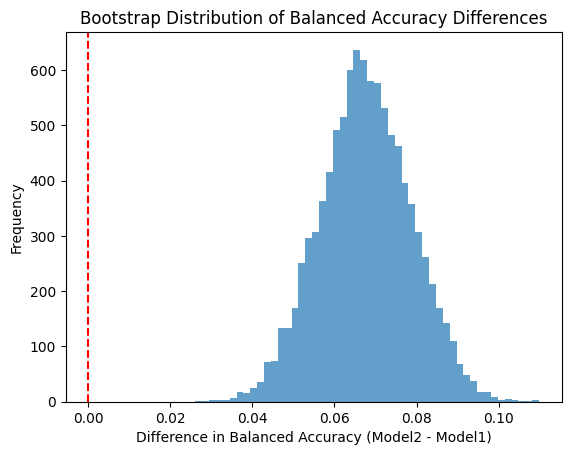

95% Confidence Interval: [0.0461, 0.0891]


In [39]:
plt.hist(diff_distribution, bins=50, alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Bootstrap Distribution of Balanced Accuracy Differences")
plt.xlabel("Difference in Balanced Accuracy (Model2 - Model1)")
plt.ylabel("Frequency")
plt.show()

lower_bound = np.percentile(diff_distribution, 2.5)
upper_bound = np.percentile(diff_distribution, 97.5)
print(f"95% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

Expected Calibration Error (ECE): 0.0303


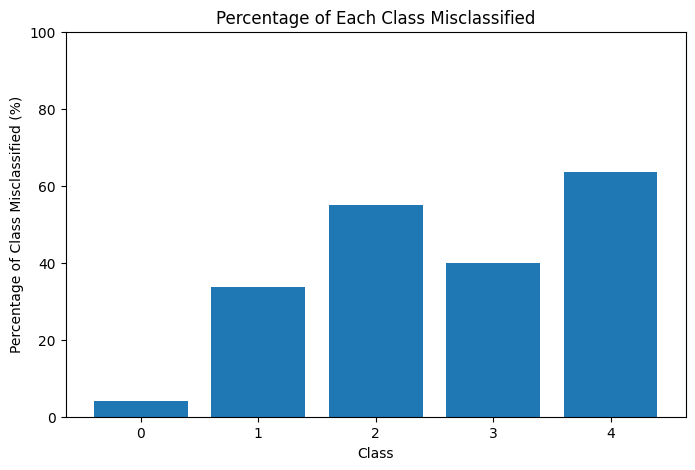

Misclassification percentages per class:
Class 0: 4.04%
Class 1: 33.82%
Class 2: 54.95%
Class 3: 40.00%
Class 4: 63.46%

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       322
           1       0.45      0.66      0.54        68
           2       0.80      0.45      0.58       182
           3       0.26      0.60      0.37        35
           4       0.37      0.37      0.37        52

    accuracy                           0.72       659
   macro avg       0.57      0.61      0.56       659
weighted avg       0.77      0.72      0.73       659



In [40]:
# After training is done for a fold
final_preds = np.array(results_class_weight['trainer'].val_preds)
final_labels = np.array(results_class_weight['trainer'].val_labels)

# Evaluate predictions
evaluation_results = evaluate_predictions(final_preds, final_labels)

### Best Model: Baseline + Class Weight + Unfreeze 2 Blocks

In this section, I extended the previous model by unfreezing the last two blocks of the EfficientNet backbone while retaining class weights. This allowed the model to fine-tune deeper features and adapt better to the dataset.

#### Key Observations:
- **Balanced Accuracy**: Achieved a slight improvement over the previous model, indicating better performance across all classes.
- **Class Performance**:
  - **Class 1**: Significant improvement, with a noticeable drop in misclassification rates and a higher F1-score.
  - **Class 4**: Marked reduction in misclassification rates and an improved F1-score, though it remains challenging.
  - **Class 3**: Performance deteriorated slightly, with an increase in misclassification rates, highlighting the need for further intervention.
  - **Class 0**: Maintained exceptional performance with minor increases in misclassification, still the best-performing class.
- **Calibration**: The Expected Calibration Error (ECE) showed further improvement, indicating more reliable predicted probabilities.

#### Statistical Significance:
- **Bootstrap Test**: The improvement in balanced accuracy was statistically significant, with a p-value of **0.0000** and a 95% confidence interval confirming the meaningful positive difference.

#### Trade-offs:
- **Overall Accuracy**: Improved slightly compared to the previous model, balancing overall performance and minority class focus.
- **Macro-Averaged Metrics**: Both the F1-score and recall improved, reflecting better generalization to minority classes, but challenges persist for Class 3.

#### Conclusion:
Unfreezing two backbone blocks helped the model achieve better differentiation for minority classes like Class 4 while maintaining strong calibration and overall performance. However, challenges with Class 3 suggest that additional targeted interventions, such as data augmentation or advanced loss functions, may further enhance performance.


In [41]:
cfg = Config()
cfg.unfreeze_blocks = 2  # Unfreeze the last 2 blocks of the backbone
custom_scaling_factors = [1.0, 1.2, 1.2, 1.5, 1.5]
results_unfreeze = run_cross_validation(cfg, ALL_IMAGES_RESIZED_DIR, custom_scaling_factors)

Starting Fold 1/5...
Unfreezing the last 2 blocks of the EfficientNet backbone...
Deleting previous results file: /content/data/snapshots/fold_0_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_0.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5138
Epoch 1: Train Loss=1.3525, Val Loss=1.1734, Val BAcc=0.5138, Kappa=0.7277, Accuracy=0.6273


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.42it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5450
Epoch 2: Train Loss=1.1463, Val Loss=1.1164, Val BAcc=0.5450, Kappa=0.7530, Accuracy=0.6667


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.45it/s]


Epoch 3: Train Loss=1.0722, Val Loss=1.1059, Val BAcc=0.5379, Kappa=0.7186, Accuracy=0.6773


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.41it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5899
Epoch 4: Train Loss=1.0451, Val Loss=1.0479, Val BAcc=0.5899, Kappa=0.7853, Accuracy=0.6985


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.58it/s]


Epoch 5: Train Loss=1.0124, Val Loss=1.0307, Val BAcc=0.5672, Kappa=0.7878, Accuracy=0.7061


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.55it/s]


Epoch 6: Train Loss=0.9794, Val Loss=1.0285, Val BAcc=0.5611, Kappa=0.7828, Accuracy=0.6894


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.36it/s]


Epoch 7: Train Loss=0.9468, Val Loss=1.0184, Val BAcc=0.5842, Kappa=0.7916, Accuracy=0.6864


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.56it/s]


Epoch 8: Train Loss=0.9158, Val Loss=1.0389, Val BAcc=0.5768, Kappa=0.7840, Accuracy=0.7030


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.95it/s]


Epoch 9: Train Loss=0.9322, Val Loss=1.0281, Val BAcc=0.5884, Kappa=0.8026, Accuracy=0.6833


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.62it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6024
Epoch 10: Train Loss=0.8916, Val Loss=1.0218, Val BAcc=0.6024, Kappa=0.8029, Accuracy=0.6924


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.40it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6122
Epoch 11: Train Loss=0.8829, Val Loss=1.0156, Val BAcc=0.6122, Kappa=0.7992, Accuracy=0.7121


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.48it/s]


Epoch 12: Train Loss=0.8675, Val Loss=1.0301, Val BAcc=0.6063, Kappa=0.8049, Accuracy=0.7000


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.47it/s]


Epoch 13: Train Loss=0.8523, Val Loss=1.0374, Val BAcc=0.5979, Kappa=0.7993, Accuracy=0.7288


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.43it/s]


Epoch 14: Train Loss=0.8409, Val Loss=1.0322, Val BAcc=0.6052, Kappa=0.8112, Accuracy=0.7121


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.45it/s]


Epoch 15: Train Loss=0.8429, Val Loss=1.0295, Val BAcc=0.5819, Kappa=0.8081, Accuracy=0.7288


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.17it/s]


Epoch 16: Train Loss=0.8211, Val Loss=1.0287, Val BAcc=0.5881, Kappa=0.8266, Accuracy=0.7348


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.76it/s]


Epoch 17: Train Loss=0.8209, Val Loss=1.0223, Val BAcc=0.5794, Kappa=0.8221, Accuracy=0.7197


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.31it/s]


Epoch 18: Train Loss=0.8091, Val Loss=1.0149, Val BAcc=0.5923, Kappa=0.8076, Accuracy=0.7227


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.28it/s]


Epoch 19: Train Loss=0.8158, Val Loss=1.0131, Val BAcc=0.5847, Kappa=0.8146, Accuracy=0.7227


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.31it/s]


Epoch 20: Train Loss=0.8066, Val Loss=1.0083, Val BAcc=0.5993, Kappa=0.8149, Accuracy=0.7197
Results for fold 0 saved to /content/data/snapshots/fold_0_results.pth.
Starting Fold 2/5...
Unfreezing the last 2 blocks of the EfficientNet backbone...
Deleting previous results file: /content/data/snapshots/fold_1_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_1.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.34it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5438
Epoch 1: Train Loss=1.3520, Val Loss=1.1754, Val BAcc=0.5438, Kappa=0.7066, Accuracy=0.6206


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.48it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5795
Epoch 2: Train Loss=1.1529, Val Loss=1.0964, Val BAcc=0.5795, Kappa=0.7626, Accuracy=0.6783


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.01it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5845
Epoch 3: Train Loss=1.0724, Val Loss=1.0367, Val BAcc=0.5845, Kappa=0.7507, Accuracy=0.7086


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.46it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5889
Epoch 4: Train Loss=1.0298, Val Loss=0.9985, Val BAcc=0.5889, Kappa=0.7714, Accuracy=0.7011


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.88it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6304
Epoch 5: Train Loss=0.9661, Val Loss=0.9849, Val BAcc=0.6304, Kappa=0.7919, Accuracy=0.7132


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.28it/s]


Epoch 6: Train Loss=0.9593, Val Loss=0.9715, Val BAcc=0.6303, Kappa=0.7979, Accuracy=0.7162


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.31it/s]


Epoch 7: Train Loss=0.9484, Val Loss=0.9709, Val BAcc=0.6253, Kappa=0.7898, Accuracy=0.7420


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.11it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6443
Epoch 8: Train Loss=0.9767, Val Loss=0.9451, Val BAcc=0.6443, Kappa=0.8091, Accuracy=0.7299


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.24it/s]


Epoch 9: Train Loss=0.9323, Val Loss=0.9631, Val BAcc=0.6002, Kappa=0.8050, Accuracy=0.7162


Validating: 100%|██████████| 21/21 [00:01<00:00, 12.26it/s]


Epoch 10: Train Loss=0.8992, Val Loss=0.9808, Val BAcc=0.6229, Kappa=0.8384, Accuracy=0.7709


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.89it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6503
Epoch 11: Train Loss=0.8789, Val Loss=0.9509, Val BAcc=0.6503, Kappa=0.8428, Accuracy=0.7587


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.08it/s]


Epoch 12: Train Loss=0.8756, Val Loss=0.9471, Val BAcc=0.6404, Kappa=0.8220, Accuracy=0.7238


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.35it/s]


Epoch 13: Train Loss=0.8667, Val Loss=0.9564, Val BAcc=0.6146, Kappa=0.8132, Accuracy=0.7162


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.22it/s]


Epoch 14: Train Loss=0.8604, Val Loss=0.9562, Val BAcc=0.6381, Kappa=0.8219, Accuracy=0.7284


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.82it/s]


Epoch 15: Train Loss=0.8543, Val Loss=0.9483, Val BAcc=0.6353, Kappa=0.8113, Accuracy=0.7117


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.23it/s]


Epoch 16: Train Loss=0.8372, Val Loss=0.9455, Val BAcc=0.6502, Kappa=0.8289, Accuracy=0.7375


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.51it/s]


Epoch 17: Train Loss=0.8387, Val Loss=0.9513, Val BAcc=0.6468, Kappa=0.8307, Accuracy=0.7314


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.94it/s]


Epoch 18: Train Loss=0.8457, Val Loss=0.9733, Val BAcc=0.6422, Kappa=0.8254, Accuracy=0.7238


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.29it/s]


Epoch 19: Train Loss=0.8327, Val Loss=0.9393, Val BAcc=0.6453, Kappa=0.8238, Accuracy=0.7269


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.01it/s]


Epoch 20: Train Loss=0.8393, Val Loss=0.9482, Val BAcc=0.6293, Kappa=0.8234, Accuracy=0.7238
Results for fold 1 saved to /content/data/snapshots/fold_1_results.pth.
Starting Fold 3/5...
Unfreezing the last 2 blocks of the EfficientNet backbone...
Deleting previous results file: /content/data/snapshots/fold_2_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_2.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.13it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5372
Epoch 1: Train Loss=1.3680, Val Loss=1.1598, Val BAcc=0.5372, Kappa=0.7369, Accuracy=0.6252


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.10it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5754
Epoch 2: Train Loss=1.1567, Val Loss=1.0710, Val BAcc=0.5754, Kappa=0.7667, Accuracy=0.6540


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.12it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5758
Epoch 3: Train Loss=1.0722, Val Loss=1.0179, Val BAcc=0.5758, Kappa=0.7869, Accuracy=0.6677


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.21it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5878
Epoch 4: Train Loss=1.0312, Val Loss=0.9968, Val BAcc=0.5878, Kappa=0.8100, Accuracy=0.7132


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.16it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6136
Epoch 5: Train Loss=1.0109, Val Loss=0.9929, Val BAcc=0.6136, Kappa=0.8163, Accuracy=0.6768


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.81it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6197
Epoch 6: Train Loss=0.9811, Val Loss=0.9630, Val BAcc=0.6197, Kappa=0.8125, Accuracy=0.6965


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.22it/s]


Epoch 7: Train Loss=0.9562, Val Loss=0.9986, Val BAcc=0.6023, Kappa=0.8333, Accuracy=0.6904


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.23it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6206
Epoch 8: Train Loss=0.9326, Val Loss=0.9448, Val BAcc=0.6206, Kappa=0.8012, Accuracy=0.7026


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.33it/s]


Epoch 9: Train Loss=0.9277, Val Loss=0.9534, Val BAcc=0.5940, Kappa=0.7973, Accuracy=0.6889


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.13it/s]


Epoch 10: Train Loss=0.9135, Val Loss=0.9377, Val BAcc=0.5975, Kappa=0.8103, Accuracy=0.7147


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.76it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6240
Epoch 11: Train Loss=0.8829, Val Loss=0.9359, Val BAcc=0.6240, Kappa=0.8303, Accuracy=0.7269


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.18it/s]


Epoch 12: Train Loss=0.8918, Val Loss=0.9459, Val BAcc=0.6236, Kappa=0.8340, Accuracy=0.7375


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.55it/s]


Epoch 13: Train Loss=0.8552, Val Loss=0.9874, Val BAcc=0.6219, Kappa=0.8400, Accuracy=0.7481


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.98it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6241
Epoch 14: Train Loss=0.8498, Val Loss=0.9728, Val BAcc=0.6241, Kappa=0.8373, Accuracy=0.6889


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.24it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6241
Epoch 15: Train Loss=0.8271, Val Loss=0.9512, Val BAcc=0.6241, Kappa=0.8426, Accuracy=0.7405


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.08it/s]


Epoch 16: Train Loss=0.8179, Val Loss=0.9347, Val BAcc=0.6226, Kappa=0.8308, Accuracy=0.7253


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.15it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6332
Epoch 17: Train Loss=0.8133, Val Loss=0.9376, Val BAcc=0.6332, Kappa=0.8338, Accuracy=0.7253


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.32it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6373
Epoch 18: Train Loss=0.8120, Val Loss=0.9445, Val BAcc=0.6373, Kappa=0.8360, Accuracy=0.7314


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.36it/s]


Epoch 19: Train Loss=0.8422, Val Loss=0.9317, Val BAcc=0.6341, Kappa=0.8382, Accuracy=0.7405


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.31it/s]


Epoch 20: Train Loss=0.8040, Val Loss=0.9478, Val BAcc=0.6308, Kappa=0.8363, Accuracy=0.7269
Results for fold 2 saved to /content/data/snapshots/fold_2_results.pth.
Starting Fold 4/5...
Unfreezing the last 2 blocks of the EfficientNet backbone...
Deleting previous results file: /content/data/snapshots/fold_3_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_3.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.23it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.5678
Epoch 1: Train Loss=1.3538, Val Loss=1.1810, Val BAcc=0.5678, Kappa=0.7564, Accuracy=0.6510


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.74it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.5745
Epoch 2: Train Loss=1.1505, Val Loss=1.1125, Val BAcc=0.5745, Kappa=0.7637, Accuracy=0.6646


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.56it/s]


Epoch 3: Train Loss=1.0769, Val Loss=1.1218, Val BAcc=0.5582, Kappa=0.7779, Accuracy=0.6464


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.07it/s]


Epoch 4: Train Loss=1.0249, Val Loss=1.1096, Val BAcc=0.5636, Kappa=0.7815, Accuracy=0.7071


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.26it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.5858
Epoch 5: Train Loss=0.9853, Val Loss=1.0650, Val BAcc=0.5858, Kappa=0.7862, Accuracy=0.6904


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.34it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6036
Epoch 6: Train Loss=0.9511, Val Loss=1.0795, Val BAcc=0.6036, Kappa=0.8030, Accuracy=0.6904


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.14it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6070
Epoch 7: Train Loss=0.9482, Val Loss=1.0384, Val BAcc=0.6070, Kappa=0.8116, Accuracy=0.7102


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.67it/s]


Epoch 8: Train Loss=0.9065, Val Loss=1.0353, Val BAcc=0.5985, Kappa=0.8200, Accuracy=0.6995


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.33it/s]


Epoch 9: Train Loss=0.9031, Val Loss=1.0211, Val BAcc=0.6010, Kappa=0.8101, Accuracy=0.6950


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.35it/s]


Epoch 10: Train Loss=0.9147, Val Loss=1.0299, Val BAcc=0.5817, Kappa=0.8252, Accuracy=0.7253


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.54it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6198
Epoch 11: Train Loss=0.8749, Val Loss=1.0257, Val BAcc=0.6198, Kappa=0.8183, Accuracy=0.7299


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.97it/s]


Epoch 12: Train Loss=0.8935, Val Loss=1.0080, Val BAcc=0.5955, Kappa=0.8242, Accuracy=0.7132


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.51it/s]


Epoch 13: Train Loss=0.8678, Val Loss=1.0322, Val BAcc=0.6129, Kappa=0.8330, Accuracy=0.7360


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.46it/s]


Epoch 14: Train Loss=0.8644, Val Loss=1.0198, Val BAcc=0.6032, Kappa=0.8116, Accuracy=0.7026


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.22it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6200
Epoch 15: Train Loss=0.8391, Val Loss=1.0058, Val BAcc=0.6200, Kappa=0.8196, Accuracy=0.7132


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.38it/s]


Epoch 16: Train Loss=0.8539, Val Loss=0.9970, Val BAcc=0.6184, Kappa=0.8256, Accuracy=0.7405


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.75it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6308
Epoch 17: Train Loss=0.8162, Val Loss=1.0084, Val BAcc=0.6308, Kappa=0.8230, Accuracy=0.7360


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.28it/s]


Epoch 18: Train Loss=0.7914, Val Loss=1.0228, Val BAcc=0.6185, Kappa=0.8310, Accuracy=0.7329


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.43it/s]


Epoch 19: Train Loss=0.8022, Val Loss=1.0231, Val BAcc=0.6242, Kappa=0.8341, Accuracy=0.7390


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.22it/s]


Epoch 20: Train Loss=0.8041, Val Loss=1.0211, Val BAcc=0.6225, Kappa=0.8272, Accuracy=0.7436
Results for fold 3 saved to /content/data/snapshots/fold_3_results.pth.
Starting Fold 5/5...
Unfreezing the last 2 blocks of the EfficientNet backbone...
Deleting previous results file: /content/data/snapshots/fold_4_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_4.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.39it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.5217
Epoch 1: Train Loss=1.3533, Val Loss=1.1553, Val BAcc=0.5217, Kappa=0.7166, Accuracy=0.6419


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.06it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.5896
Epoch 2: Train Loss=1.1684, Val Loss=1.0405, Val BAcc=0.5896, Kappa=0.7703, Accuracy=0.7026


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.54it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6205
Epoch 3: Train Loss=1.0942, Val Loss=0.9778, Val BAcc=0.6205, Kappa=0.7974, Accuracy=0.7284


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.52it/s]


Epoch 4: Train Loss=1.0254, Val Loss=0.9633, Val BAcc=0.6125, Kappa=0.8156, Accuracy=0.7557


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.23it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6399
Epoch 5: Train Loss=1.0034, Val Loss=0.9274, Val BAcc=0.6399, Kappa=0.8291, Accuracy=0.7436


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.48it/s]


Epoch 6: Train Loss=0.9848, Val Loss=0.9161, Val BAcc=0.6388, Kappa=0.8305, Accuracy=0.7496


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.19it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6416
Epoch 7: Train Loss=0.9735, Val Loss=0.8995, Val BAcc=0.6416, Kappa=0.8381, Accuracy=0.7314


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.47it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6424
Epoch 8: Train Loss=0.9502, Val Loss=0.8871, Val BAcc=0.6424, Kappa=0.8251, Accuracy=0.7360


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.54it/s]


Epoch 9: Train Loss=0.9295, Val Loss=0.8958, Val BAcc=0.6414, Kappa=0.8551, Accuracy=0.7739


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.43it/s]


Epoch 10: Train Loss=0.9191, Val Loss=0.8665, Val BAcc=0.6169, Kappa=0.8455, Accuracy=0.7344


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.57it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6619
Epoch 11: Train Loss=0.9039, Val Loss=0.8752, Val BAcc=0.6619, Kappa=0.8614, Accuracy=0.7557


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.90it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6657
Epoch 12: Train Loss=0.9064, Val Loss=0.8953, Val BAcc=0.6657, Kappa=0.8579, Accuracy=0.7785


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.48it/s]


Epoch 13: Train Loss=0.8903, Val Loss=0.9015, Val BAcc=0.6250, Kappa=0.8279, Accuracy=0.7147


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.51it/s]


Epoch 14: Train Loss=0.8572, Val Loss=0.8766, Val BAcc=0.6538, Kappa=0.8404, Accuracy=0.7511


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.57it/s]


Epoch 15: Train Loss=0.8605, Val Loss=0.8568, Val BAcc=0.6478, Kappa=0.8620, Accuracy=0.7466


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.18it/s]


Epoch 16: Train Loss=0.8603, Val Loss=0.8664, Val BAcc=0.6513, Kappa=0.8504, Accuracy=0.7451


Validating: 100%|██████████| 21/21 [00:01<00:00, 13.86it/s]


Epoch 17: Train Loss=0.8454, Val Loss=0.8639, Val BAcc=0.6594, Kappa=0.8583, Accuracy=0.7633


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.59it/s]


Epoch 18: Train Loss=0.8308, Val Loss=0.8591, Val BAcc=0.6506, Kappa=0.8581, Accuracy=0.7511


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.45it/s]


Epoch 19: Train Loss=0.8198, Val Loss=0.8512, Val BAcc=0.6632, Kappa=0.8662, Accuracy=0.7557


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.36it/s]

Epoch 20: Train Loss=0.8384, Val Loss=0.8631, Val BAcc=0.6596, Kappa=0.8584, Accuracy=0.7602
Results for fold 4 saved to /content/data/snapshots/fold_4_results.pth.
Mean Balanced Accuracy across 5 folds: 0.6393 ± 0.0180
Mean Kappa across 5 folds: 0.8424 ± 0.0133
Mean Accuracy across 5 folds: 0.7552 ± 0.0167


In [42]:
improved_oof_preds, improved_oof_labels = get_oof_predictions(cfg, ALL_IMAGES_RESIZED_DIR, folds)

<ipython-input-24-4f4db3afa07a>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=cfg.device))


Unfreezing the last 2 blocks of the EfficientNet backbone...
Unfreezing the last 2 blocks of the EfficientNet backbone...
Unfreezing the last 2 blocks of the EfficientNet backbone...
Unfreezing the last 2 blocks of the EfficientNet backbone...
Unfreezing the last 2 blocks of the EfficientNet backbone...


In [43]:
# Ensure that baseline_oof_labels == improved_oof_labels for a fair comparison.
assert np.array_equal(baseline_oof_labels, improved_oof_labels), "Labels must match!"
y_true = baseline_oof_labels  # They are the same for both models

p_value, diff_distribution = bootstrap_test(
    y_true=y_true,
    preds_model1=baseline_oof_preds,
    preds_model2=improved_oof_preds,
    n_bootstraps=10000,
    random_state=42
)

print(f"Bootstrap p-value: {p_value:.4f}")

Bootstrap p-value: 0.0000


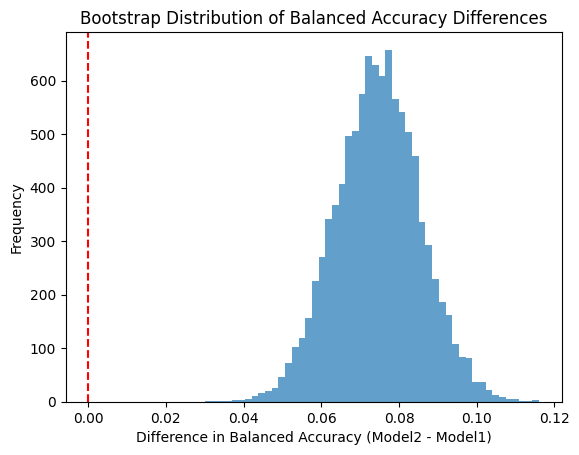

95% Confidence Interval: [0.0531, 0.0963]


In [44]:
plt.hist(diff_distribution, bins=50, alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Bootstrap Distribution of Balanced Accuracy Differences")
plt.xlabel("Difference in Balanced Accuracy (Model2 - Model1)")
plt.ylabel("Frequency")
plt.show()

lower_bound = np.percentile(diff_distribution, 2.5)
upper_bound = np.percentile(diff_distribution, 97.5)
print(f"95% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

Expected Calibration Error (ECE): 0.0317


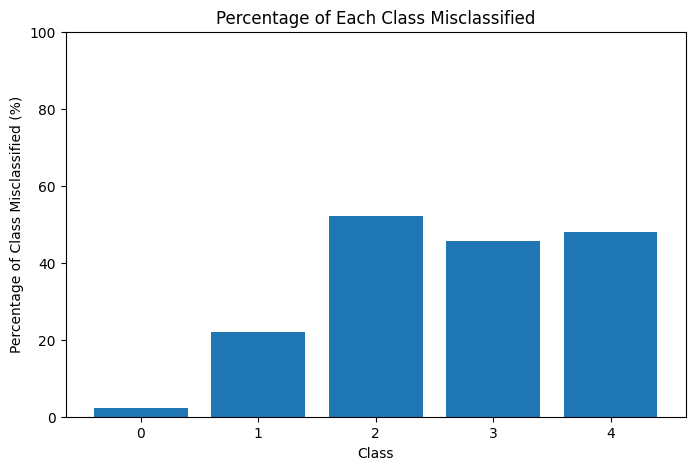

Misclassification percentages per class:
Class 0: 2.17%
Class 1: 22.06%
Class 2: 52.20%
Class 3: 45.71%
Class 4: 48.08%

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       322
           1       0.45      0.78      0.57        68
           2       0.87      0.48      0.62       182
           3       0.33      0.54      0.41        35
           4       0.52      0.52      0.52        52

    accuracy                           0.76       659
   macro avg       0.62      0.66      0.62       659
weighted avg       0.81      0.76      0.76       659



In [45]:
# After training is done for a fold
final_preds = np.array(results_unfreeze['trainer'].val_preds)
final_labels = np.array(results_unfreeze['trainer'].val_labels)

# Evaluate predictions
evaluation_results = evaluate_predictions(final_preds, final_labels)

# Pre-caching Resize Images to 380x380

In [46]:
ALL_IMAGES_DIR = '/content/data/all_images'
ALL_IMAGES_RESIZED_DIR_380 = '/content/data/all_images_resized_380'
IMG_SIZE = 380

os.makedirs(ALL_IMAGES_RESIZED_DIR_380, exist_ok=True)

img_paths = glob.glob(os.path.join(ALL_IMAGES_DIR, '*.png'))

for img_path in tqdm(img_paths, desc="Resizing"):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #Ben Graham's Pre-processing
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), 10), -4, 128)


    img_save = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    base_name = os.path.basename(img_path)
    cv2.imwrite(os.path.join(ALL_IMAGES_RESIZED_DIR_380, base_name), img_save)

Resizing: 100%|██████████| 3296/3296 [09:57<00:00,  5.52it/s]


### EfficientNet-B4

In this section, I experimented with EfficientNet-B4, a larger and more complex architecture, to evaluate its impact on performance. Images were resized to **380x380**, and training followed the same strategies as the EfficientNet-B0 experiment, including class weights.

#### Key Observations:
- **Balanced Accuracy**: Improved slightly compared to EfficientNet-B0, achieving a marginal gain across classes.
- **Overall Accuracy**: Increased slightly, suggesting some improvement in overall predictions.
- **Calibration**: The Expected Calibration Error (ECE) improved compared to previous experiments, indicating more reliable probability estimates.

- **Class Performance**:
  - **Class 2**: Continued to show challenges, with a high misclassification rate but steady performance compared to EfficientNet-B0.
  - **Class 3 and Class 4**: These classes remain difficult to classify, with persistently high misclassification rates, though some improvement was observed for Class 4.

#### Trade-offs:
- **Training Time**: Increased significantly, from **~10 minutes (EfficientNet-B0)** to **~50 minutes (EfficientNet-B4)**, making this approach computationally expensive.
- **Complexity vs. Performance**: The increased complexity provided limited performance gains, suggesting that EfficientNet-B4 might not be the most practical choice for this task.

#### Conclusion:
EfficientNet-B4 offered slight improvements in balanced accuracy, overall accuracy, and calibration compared to EfficientNet-B0. However, the computational cost and persistent challenges with minority classes, especially Class 3, make EfficientNet-B0 a more efficient and balanced choice for this dataset.



In [47]:
cfg = Config()
cfg.model_name = "efficientnet-b4"  # Switch to EfficientNet-B4
cfg.variant = "b4"
cfg.image_size = 380  # Update resolution for B4
cfg.batch_size = 16  # Reduce batch size for memory constraints
cfg.save_dir = Path("/content/data/snapshots-B4")  # Change save directory for B4
cfg.save_dir.mkdir(parents=True, exist_ok=True)
custom_scaling_factors = [1.0, 1.2, 1.2, 1.5, 1.5]  # Define custom weights for B4



results_b4 = run_cross_validation(cfg, ALL_IMAGES_RESIZED_DIR_380, custom_scaling_factors)

Starting Fold 1/5...


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:02<00:00, 38.7MB/s]
Validating: 100%|██████████| 42/42 [00:07<00:00,  5.95it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5418
Epoch 1: Train Loss=1.4093, Val Loss=1.2509, Val BAcc=0.5418, Kappa=0.7289, Accuracy=0.6667


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.07it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5797
Epoch 2: Train Loss=1.2207, Val Loss=1.1581, Val BAcc=0.5797, Kappa=0.7307, Accuracy=0.6500


Validating: 100%|██████████| 42/42 [00:07<00:00,  6.00it/s]


Epoch 3: Train Loss=1.1474, Val Loss=1.0985, Val BAcc=0.5752, Kappa=0.7374, Accuracy=0.7273


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.04it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5802
Epoch 4: Train Loss=1.0967, Val Loss=1.0635, Val BAcc=0.5802, Kappa=0.7207, Accuracy=0.6712


Validating: 100%|██████████| 42/42 [00:07<00:00,  5.99it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6267
Epoch 5: Train Loss=1.0580, Val Loss=1.0201, Val BAcc=0.6267, Kappa=0.7766, Accuracy=0.7515


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.04it/s]


Epoch 6: Train Loss=1.0266, Val Loss=0.9973, Val BAcc=0.6185, Kappa=0.7831, Accuracy=0.7500


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


Epoch 7: Train Loss=1.0066, Val Loss=0.9887, Val BAcc=0.6089, Kappa=0.7651, Accuracy=0.7167


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 8: Train Loss=0.9942, Val Loss=0.9960, Val BAcc=0.6189, Kappa=0.7585, Accuracy=0.7136


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6484
Epoch 9: Train Loss=0.9899, Val Loss=0.9677, Val BAcc=0.6484, Kappa=0.7729, Accuracy=0.7364


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6490
Epoch 10: Train Loss=0.9821, Val Loss=0.9424, Val BAcc=0.6490, Kappa=0.8049, Accuracy=0.7258


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 11: Train Loss=0.9640, Val Loss=0.9464, Val BAcc=0.6307, Kappa=0.7929, Accuracy=0.7318


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 12: Train Loss=0.9523, Val Loss=0.9451, Val BAcc=0.6420, Kappa=0.7995, Accuracy=0.7152


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 13: Train Loss=0.9540, Val Loss=0.9364, Val BAcc=0.6409, Kappa=0.8072, Accuracy=0.7727


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.04it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6554
Epoch 14: Train Loss=0.9322, Val Loss=0.9335, Val BAcc=0.6554, Kappa=0.8056, Accuracy=0.7591


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 15: Train Loss=0.9290, Val Loss=0.9144, Val BAcc=0.6520, Kappa=0.8109, Accuracy=0.7258


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 16: Train Loss=0.9235, Val Loss=0.9217, Val BAcc=0.6450, Kappa=0.8055, Accuracy=0.7682


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6636
Epoch 17: Train Loss=0.8976, Val Loss=0.8971, Val BAcc=0.6636, Kappa=0.7968, Accuracy=0.7394


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.00it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6640
Epoch 18: Train Loss=0.9212, Val Loss=0.8839, Val BAcc=0.6640, Kappa=0.8282, Accuracy=0.7439


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6691
Epoch 19: Train Loss=0.8900, Val Loss=0.8981, Val BAcc=0.6691, Kappa=0.8140, Accuracy=0.7500


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.03it/s]


Epoch 20: Train Loss=0.9084, Val Loss=0.8868, Val BAcc=0.6659, Kappa=0.8175, Accuracy=0.7530
Results for fold 0 saved to /content/data/snapshots-B4/fold_0_results.pth.
Starting Fold 2/5...


Validating: 100%|██████████| 42/42 [00:07<00:00,  5.96it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5556
Epoch 1: Train Loss=1.4061, Val Loss=1.2674, Val BAcc=0.5556, Kappa=0.7476, Accuracy=0.6328


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.05it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5671
Epoch 2: Train Loss=1.2103, Val Loss=1.1526, Val BAcc=0.5671, Kappa=0.7502, Accuracy=0.7026


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5869
Epoch 3: Train Loss=1.1514, Val Loss=1.0966, Val BAcc=0.5869, Kappa=0.7860, Accuracy=0.7269


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 4: Train Loss=1.1064, Val Loss=1.0786, Val BAcc=0.5714, Kappa=0.7616, Accuracy=0.6889


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6076
Epoch 5: Train Loss=1.0676, Val Loss=1.0423, Val BAcc=0.6076, Kappa=0.7809, Accuracy=0.7011


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


Epoch 6: Train Loss=1.0437, Val Loss=1.0268, Val BAcc=0.5892, Kappa=0.7843, Accuracy=0.7238


Validating: 100%|██████████| 42/42 [00:07<00:00,  6.00it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6189
Epoch 7: Train Loss=1.0213, Val Loss=1.0417, Val BAcc=0.6189, Kappa=0.7753, Accuracy=0.7238


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6194
Epoch 8: Train Loss=1.0177, Val Loss=0.9781, Val BAcc=0.6194, Kappa=0.7955, Accuracy=0.7162


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6384
Epoch 9: Train Loss=0.9874, Val Loss=0.9607, Val BAcc=0.6384, Kappa=0.8095, Accuracy=0.7223


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.03it/s]


Epoch 10: Train Loss=0.9662, Val Loss=0.9606, Val BAcc=0.6379, Kappa=0.8136, Accuracy=0.7299


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 11: Train Loss=0.9647, Val Loss=0.9769, Val BAcc=0.6270, Kappa=0.7957, Accuracy=0.7314


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 12: Train Loss=0.9738, Val Loss=0.9857, Val BAcc=0.6201, Kappa=0.7937, Accuracy=0.7344


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 13: Train Loss=0.9647, Val Loss=0.9651, Val BAcc=0.6124, Kappa=0.7980, Accuracy=0.7451


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.04it/s]


Epoch 14: Train Loss=0.9501, Val Loss=0.9519, Val BAcc=0.6318, Kappa=0.8032, Accuracy=0.7451


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


Epoch 15: Train Loss=0.9374, Val Loss=0.9820, Val BAcc=0.6079, Kappa=0.7898, Accuracy=0.7375


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 16: Train Loss=0.9229, Val Loss=0.9783, Val BAcc=0.6229, Kappa=0.7982, Accuracy=0.7360


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.00it/s]


Epoch 17: Train Loss=0.9365, Val Loss=0.9693, Val BAcc=0.6321, Kappa=0.7998, Accuracy=0.7390


Validating: 100%|██████████| 42/42 [00:07<00:00,  6.00it/s]


Epoch 18: Train Loss=0.9233, Val Loss=0.9714, Val BAcc=0.6347, Kappa=0.7926, Accuracy=0.7375


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.03it/s]


Epoch 19: Train Loss=0.9466, Val Loss=0.9646, Val BAcc=0.6153, Kappa=0.7893, Accuracy=0.7299


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


Epoch 20: Train Loss=0.9340, Val Loss=0.9672, Val BAcc=0.6282, Kappa=0.7942, Accuracy=0.7375
Results for fold 1 saved to /content/data/snapshots-B4/fold_1_results.pth.
Starting Fold 3/5...


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5169
Epoch 1: Train Loss=1.4122, Val Loss=1.2825, Val BAcc=0.5169, Kappa=0.7963, Accuracy=0.6388


Validating: 100%|██████████| 42/42 [00:07<00:00,  6.00it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5371
Epoch 2: Train Loss=1.2324, Val Loss=1.1685, Val BAcc=0.5371, Kappa=0.7647, Accuracy=0.6540


Validating: 100%|██████████| 42/42 [00:07<00:00,  6.00it/s]


Epoch 3: Train Loss=1.1369, Val Loss=1.1367, Val BAcc=0.5304, Kappa=0.7699, Accuracy=0.6753


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5835
Epoch 4: Train Loss=1.0953, Val Loss=1.0820, Val BAcc=0.5835, Kappa=0.7912, Accuracy=0.6798


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.05it/s]


Epoch 5: Train Loss=1.0665, Val Loss=1.0670, Val BAcc=0.5825, Kappa=0.8166, Accuracy=0.6904


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6017
Epoch 6: Train Loss=1.0259, Val Loss=1.0496, Val BAcc=0.6017, Kappa=0.8127, Accuracy=0.7178


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6025
Epoch 7: Train Loss=1.0218, Val Loss=1.0379, Val BAcc=0.6025, Kappa=0.8215, Accuracy=0.7314


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.04it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6139
Epoch 8: Train Loss=0.9956, Val Loss=1.0150, Val BAcc=0.6139, Kappa=0.8378, Accuracy=0.7360


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6196
Epoch 9: Train Loss=0.9845, Val Loss=1.0204, Val BAcc=0.6196, Kappa=0.8153, Accuracy=0.7208


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.00it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6265
Epoch 10: Train Loss=0.9764, Val Loss=1.0026, Val BAcc=0.6265, Kappa=0.8449, Accuracy=0.7587


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 11: Train Loss=0.9583, Val Loss=1.0075, Val BAcc=0.6128, Kappa=0.8232, Accuracy=0.7375


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.04it/s]


Epoch 12: Train Loss=0.9571, Val Loss=1.0109, Val BAcc=0.6125, Kappa=0.8243, Accuracy=0.7344


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.03it/s]


Epoch 13: Train Loss=0.9394, Val Loss=0.9931, Val BAcc=0.6135, Kappa=0.8369, Accuracy=0.7329


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.00it/s]


Epoch 14: Train Loss=0.9436, Val Loss=0.9977, Val BAcc=0.6219, Kappa=0.8399, Accuracy=0.7587


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 15: Train Loss=0.9341, Val Loss=1.0041, Val BAcc=0.6205, Kappa=0.8370, Accuracy=0.7496


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.03it/s]


Epoch 16: Train Loss=0.9143, Val Loss=0.9855, Val BAcc=0.6263, Kappa=0.8216, Accuracy=0.7375


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.00it/s]


Epoch 17: Train Loss=0.9191, Val Loss=0.9966, Val BAcc=0.6164, Kappa=0.8415, Accuracy=0.7390


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6291
Epoch 18: Train Loss=0.8932, Val Loss=0.9740, Val BAcc=0.6291, Kappa=0.8423, Accuracy=0.7420


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.00it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6332
Epoch 19: Train Loss=0.9026, Val Loss=0.9820, Val BAcc=0.6332, Kappa=0.8382, Accuracy=0.7542


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 20: Train Loss=0.8924, Val Loss=1.0010, Val BAcc=0.6188, Kappa=0.8473, Accuracy=0.7511
Results for fold 2 saved to /content/data/snapshots-B4/fold_2_results.pth.
Starting Fold 4/5...


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.4964
Epoch 1: Train Loss=1.4077, Val Loss=1.3003, Val BAcc=0.4964, Kappa=0.6875, Accuracy=0.6753


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.5399
Epoch 2: Train Loss=1.2148, Val Loss=1.1822, Val BAcc=0.5399, Kappa=0.7591, Accuracy=0.6813


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.03it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.5931
Epoch 3: Train Loss=1.1442, Val Loss=1.0968, Val BAcc=0.5931, Kappa=0.8104, Accuracy=0.6844


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.03it/s]


Epoch 4: Train Loss=1.0857, Val Loss=1.0856, Val BAcc=0.5668, Kappa=0.7962, Accuracy=0.6601


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


Epoch 5: Train Loss=1.0708, Val Loss=1.0526, Val BAcc=0.5914, Kappa=0.8272, Accuracy=0.7117


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.05it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6098
Epoch 6: Train Loss=1.0305, Val Loss=1.0363, Val BAcc=0.6098, Kappa=0.8285, Accuracy=0.7208


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6167
Epoch 7: Train Loss=1.0079, Val Loss=1.0264, Val BAcc=0.6167, Kappa=0.8362, Accuracy=0.7223


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6227
Epoch 8: Train Loss=1.0012, Val Loss=1.0121, Val BAcc=0.6227, Kappa=0.8439, Accuracy=0.7269


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.03it/s]


Epoch 9: Train Loss=0.9638, Val Loss=1.0114, Val BAcc=0.6086, Kappa=0.8392, Accuracy=0.6995


Validating: 100%|██████████| 42/42 [00:07<00:00,  5.98it/s]


Epoch 10: Train Loss=0.9641, Val Loss=1.0174, Val BAcc=0.6034, Kappa=0.8274, Accuracy=0.7269


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 11: Train Loss=0.9535, Val Loss=1.0007, Val BAcc=0.6175, Kappa=0.8357, Accuracy=0.7405


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6246
Epoch 12: Train Loss=0.9800, Val Loss=0.9960, Val BAcc=0.6246, Kappa=0.8402, Accuracy=0.7178


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 13: Train Loss=0.9571, Val Loss=0.9626, Val BAcc=0.6196, Kappa=0.8182, Accuracy=0.7026


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.05it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6347
Epoch 14: Train Loss=0.9182, Val Loss=0.9730, Val BAcc=0.6347, Kappa=0.8509, Accuracy=0.7314


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6355
Epoch 15: Train Loss=0.9239, Val Loss=0.9741, Val BAcc=0.6355, Kappa=0.8448, Accuracy=0.7132


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 16: Train Loss=0.9285, Val Loss=0.9754, Val BAcc=0.6253, Kappa=0.8398, Accuracy=0.7269


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.03it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6372
Epoch 17: Train Loss=0.9311, Val Loss=0.9599, Val BAcc=0.6372, Kappa=0.8567, Accuracy=0.7466


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6498
Epoch 18: Train Loss=0.8869, Val Loss=0.9618, Val BAcc=0.6498, Kappa=0.8513, Accuracy=0.7405


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.04it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6655
Epoch 19: Train Loss=0.9164, Val Loss=0.9417, Val BAcc=0.6655, Kappa=0.8558, Accuracy=0.7436


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.03it/s]


Epoch 20: Train Loss=0.8899, Val Loss=0.9393, Val BAcc=0.6407, Kappa=0.8578, Accuracy=0.7511
Results for fold 3 saved to /content/data/snapshots-B4/fold_3_results.pth.
Starting Fold 5/5...


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.5334
Epoch 1: Train Loss=1.4102, Val Loss=1.2573, Val BAcc=0.5334, Kappa=0.7454, Accuracy=0.6267


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.5721
Epoch 2: Train Loss=1.2220, Val Loss=1.1537, Val BAcc=0.5721, Kappa=0.8046, Accuracy=0.6859


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 3: Train Loss=1.1454, Val Loss=1.0848, Val BAcc=0.5589, Kappa=0.7946, Accuracy=0.7238


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.5893
Epoch 4: Train Loss=1.1104, Val Loss=1.0284, Val BAcc=0.5893, Kappa=0.8081, Accuracy=0.6783


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6038
Epoch 5: Train Loss=1.0771, Val Loss=1.0144, Val BAcc=0.6038, Kappa=0.8112, Accuracy=0.7375


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.03it/s]


Epoch 6: Train Loss=1.0402, Val Loss=0.9896, Val BAcc=0.5946, Kappa=0.8243, Accuracy=0.7405


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6054
Epoch 7: Train Loss=1.0133, Val Loss=0.9693, Val BAcc=0.6054, Kappa=0.8247, Accuracy=0.7375


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6154
Epoch 8: Train Loss=1.0144, Val Loss=0.9486, Val BAcc=0.6154, Kappa=0.8340, Accuracy=0.7527


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 9: Train Loss=0.9922, Val Loss=0.9430, Val BAcc=0.6021, Kappa=0.8267, Accuracy=0.7329


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


Epoch 10: Train Loss=0.9773, Val Loss=0.9680, Val BAcc=0.5881, Kappa=0.8268, Accuracy=0.7436


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6275
Epoch 11: Train Loss=0.9674, Val Loss=0.9368, Val BAcc=0.6275, Kappa=0.8418, Accuracy=0.7542


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


Epoch 12: Train Loss=0.9677, Val Loss=0.9348, Val BAcc=0.6162, Kappa=0.8350, Accuracy=0.7527


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.03it/s]


Epoch 13: Train Loss=0.9432, Val Loss=0.9356, Val BAcc=0.6139, Kappa=0.8342, Accuracy=0.7329


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.03it/s]


Epoch 14: Train Loss=0.9171, Val Loss=0.9265, Val BAcc=0.6000, Kappa=0.8333, Accuracy=0.7481


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 15: Train Loss=0.9295, Val Loss=0.9221, Val BAcc=0.6014, Kappa=0.8372, Accuracy=0.7193


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.00it/s]


Epoch 16: Train Loss=0.9058, Val Loss=0.9397, Val BAcc=0.6063, Kappa=0.8536, Accuracy=0.7936


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 17: Train Loss=0.9255, Val Loss=0.9232, Val BAcc=0.6033, Kappa=0.8461, Accuracy=0.7800


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 18: Train Loss=0.9102, Val Loss=0.9191, Val BAcc=0.6133, Kappa=0.8437, Accuracy=0.7496


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch 19: Train Loss=0.9168, Val Loss=0.9163, Val BAcc=0.6112, Kappa=0.8375, Accuracy=0.7557


Validating: 100%|██████████| 42/42 [00:06<00:00,  6.03it/s]

Epoch 20: Train Loss=0.9101, Val Loss=0.9206, Val BAcc=0.6056, Kappa=0.8370, Accuracy=0.7284
Results for fold 4 saved to /content/data/snapshots-B4/fold_4_results.pth.
Mean Balanced Accuracy across 5 folds: 0.6468 ± 0.0172
Mean Kappa across 5 folds: 0.8401 ± 0.0167
Mean Accuracy across 5 folds: 0.7643 ± 0.0174


Expected Calibration Error (ECE): 0.0439


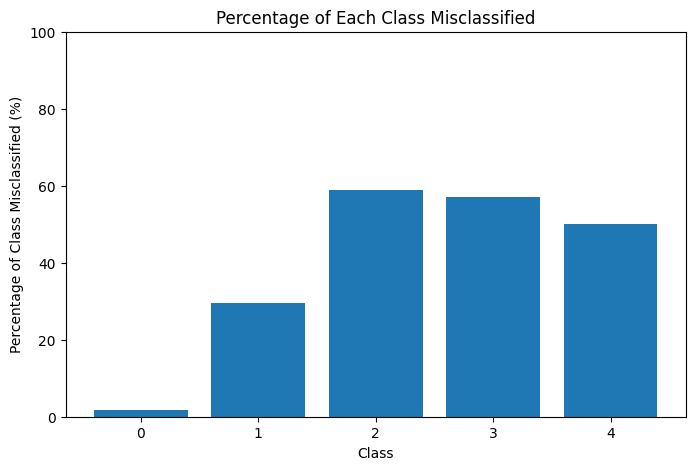

Misclassification percentages per class:
Class 0: 1.86%
Class 1: 29.41%
Class 2: 58.79%
Class 3: 57.14%
Class 4: 50.00%

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       322
           1       0.43      0.71      0.53        68
           2       0.77      0.41      0.54       182
           3       0.25      0.43      0.32        35
           4       0.41      0.50      0.45        52

    accuracy                           0.73       659
   macro avg       0.57      0.61      0.56       659
weighted avg       0.77      0.73      0.73       659



In [48]:
# After training is done for a fold
final_preds = np.array(results_b4['trainer'].val_preds)
final_labels = np.array(results_b4['trainer'].val_labels)

# Evaluate predictions
evaluation_results = evaluate_predictions(final_preds, final_labels)

### Advanced Data Augmentation & FocalLoss

In this final section, I explored advanced data augmentation techniques combined with the FocalLoss function to address class imbalance and improve model generalization. The objective was to focus the model's learning on harder-to-classify samples while enhancing data diversity.

#### Key Observations:
- **Minimal Improvement**:
  - **Balanced Accuracy**: Remained comparable to the setup with class weights and unfreezing 2 blocks, showing no meaningful improvement.
  - **Kappa and Accuracy**: Showed marginal or no gains, with accuracy slightly lower than earlier setups.
- **Calibration**: The Expected Calibration Error (ECE) worsened, indicating less reliable probability estimates.

#### Classification Metrics:
- **Class 3**: Misclassification reduced slightly, but recall and F1-score remained suboptimal, showing the class is still challenging for the model.
- **Class 4**: Some improvement in misclassification rates, but overall performance remains limited.
- **Class 0**: Maintained strong performance with minimal misclassification, consistent across setups.

#### Trade-offs:
- **No Significant Performance Gains**: Despite the added complexity, the model's overall performance, especially for minority classes, showed only marginal improvements.
- **Calibration vs. Class Focus**: While FocalLoss aimed to improve minority class handling, it resulted in worse calibration.
- **Increased Computational Overhead**: The inclusion of advanced augmentations added training complexity without yielding meaningful benefits.

#### Conclusion:
The combination of advanced augmentations and FocalLoss did not lead to significant improvements over simpler approaches like class weights and unfreezing 2 blocks. Calibration worsened, and performance gains for minority classes were marginal. This suggests that further exploration of strategies for handling imbalanced data is needed to achieve meaningful improvements.


In [ ]:
def get_train_transforms(img_size=256):
    return A.Compose([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        A.ElasticTransform(alpha=1, sigma=50, p=0.3),
        A.Rotate(limit=15, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=0, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Class weights
        self.gamma = gamma

    def forward(self, logits, labels):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(logits, labels)
        pt = torch.exp(-ce_loss)  # Probability of true class
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()


In [ ]:
# Update Config for Advanced Data Augmentation & FocalLoss
cfg = Config()
cfg.model_name = "efficientnet-b0"  # Continue using EfficientNet-B0
cfg.variant = "b0"  # EfficientNet-B0 variant

cfg.image_size = 256  # Default resolution
cfg.batch_size = 32  # Batch size suitable for EfficientNet-B0
cfg.use_focal_loss = True  # Switch to FocalLoss for this experiment

cfg.unfreeze_blocks = 2  # Unfreeze the last 2 blocks of the backbone

# Advanced Data Augmentation
custom_scaling_factors = [1.0, 1.2, 1.2, 1.5, 1.5]  # Emphasize minority classes
results_advanced = run_cross_validation(cfg, ALL_IMAGES_RESIZED_DIR, custom_scaling_factors)

Starting Fold 1/5...
Unfreezing the last 2 blocks of the EfficientNet backbone...
Deleting previous results file: /content/data/snapshots/fold_0_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_0.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5299
Epoch 1: Train Loss=8.5463, Val Loss=7.3453, Val BAcc=0.5299, Kappa=0.7450, Accuracy=0.6409


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.75it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5715
Epoch 2: Train Loss=7.2339, Val Loss=6.9241, Val BAcc=0.5715, Kappa=0.7528, Accuracy=0.6939


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.82it/s]


Epoch 3: Train Loss=6.8259, Val Loss=6.6843, Val BAcc=0.5543, Kappa=0.7659, Accuracy=0.6742


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.77it/s]


Epoch 4: Train Loss=6.6030, Val Loss=6.8541, Val BAcc=0.5679, Kappa=0.7408, Accuracy=0.6924


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.73it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6007
Epoch 5: Train Loss=6.2848, Val Loss=6.5286, Val BAcc=0.6007, Kappa=0.7674, Accuracy=0.7152


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.40it/s]


Epoch 6: Train Loss=6.0105, Val Loss=6.5588, Val BAcc=0.5817, Kappa=0.7644, Accuracy=0.7091


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.92it/s]


Epoch 7: Train Loss=5.9037, Val Loss=6.4854, Val BAcc=0.5746, Kappa=0.7895, Accuracy=0.6985


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.95it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6152
Epoch 8: Train Loss=5.8337, Val Loss=6.3452, Val BAcc=0.6152, Kappa=0.7855, Accuracy=0.7076


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.92it/s]


Epoch 9: Train Loss=5.7532, Val Loss=6.4106, Val BAcc=0.6075, Kappa=0.7849, Accuracy=0.6879


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.88it/s]


Epoch 10: Train Loss=5.6637, Val Loss=6.4742, Val BAcc=0.5970, Kappa=0.7743, Accuracy=0.7061


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.45it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6225
Epoch 11: Train Loss=5.5408, Val Loss=6.3585, Val BAcc=0.6225, Kappa=0.8198, Accuracy=0.7258


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.91it/s]


Epoch 12: Train Loss=5.2843, Val Loss=6.3668, Val BAcc=0.6216, Kappa=0.7874, Accuracy=0.7045


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6235
Epoch 13: Train Loss=5.2803, Val Loss=6.3865, Val BAcc=0.6235, Kappa=0.8199, Accuracy=0.7258


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 14: Train Loss=5.2320, Val Loss=6.3844, Val BAcc=0.6139, Kappa=0.8009, Accuracy=0.7227


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.55it/s]


Epoch 15: Train Loss=5.3339, Val Loss=6.3592, Val BAcc=0.6181, Kappa=0.8024, Accuracy=0.7197


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.64it/s]


Epoch 16: Train Loss=5.3596, Val Loss=6.3606, Val BAcc=0.6172, Kappa=0.8134, Accuracy=0.7227


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.82it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6302
Epoch 17: Train Loss=5.1696, Val Loss=6.4245, Val BAcc=0.6302, Kappa=0.8174, Accuracy=0.7303


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.33it/s]


Epoch 18: Train Loss=5.2406, Val Loss=6.3458, Val BAcc=0.6235, Kappa=0.8132, Accuracy=0.7242


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.67it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6315
Epoch 19: Train Loss=5.2484, Val Loss=6.3628, Val BAcc=0.6315, Kappa=0.8090, Accuracy=0.7258


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.69it/s]


Epoch 20: Train Loss=5.3202, Val Loss=6.3249, Val BAcc=0.6192, Kappa=0.8048, Accuracy=0.7182
Results for fold 0 saved to /content/data/snapshots/fold_0_results.pth.
Starting Fold 2/5...
Unfreezing the last 2 blocks of the EfficientNet backbone...
Deleting previous results file: /content/data/snapshots/fold_1_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_1.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.70it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5034
Epoch 1: Train Loss=8.4984, Val Loss=7.5075, Val BAcc=0.5034, Kappa=0.7088, Accuracy=0.6055


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.90it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5694
Epoch 2: Train Loss=7.2350, Val Loss=7.0984, Val BAcc=0.5694, Kappa=0.7570, Accuracy=0.6692


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.06it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5945
Epoch 3: Train Loss=6.8276, Val Loss=6.7536, Val BAcc=0.5945, Kappa=0.7828, Accuracy=0.6692


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 4: Train Loss=6.5112, Val Loss=6.6899, Val BAcc=0.5929, Kappa=0.7970, Accuracy=0.7071


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6034
Epoch 5: Train Loss=6.3105, Val Loss=6.7051, Val BAcc=0.6034, Kappa=0.8347, Accuracy=0.7344


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.89it/s]


Epoch 6: Train Loss=6.0286, Val Loss=6.4757, Val BAcc=0.5982, Kappa=0.7957, Accuracy=0.7147


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 7: Train Loss=5.8218, Val Loss=6.4828, Val BAcc=0.6034, Kappa=0.8090, Accuracy=0.7314


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.28it/s]


Epoch 8: Train Loss=5.8735, Val Loss=6.5835, Val BAcc=0.5944, Kappa=0.8042, Accuracy=0.7269


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6195
Epoch 9: Train Loss=5.7492, Val Loss=6.4526, Val BAcc=0.6195, Kappa=0.8240, Accuracy=0.7284


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.91it/s]


Epoch 10: Train Loss=5.4234, Val Loss=6.5152, Val BAcc=0.6023, Kappa=0.8120, Accuracy=0.7132


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 11: Train Loss=5.5266, Val Loss=6.4381, Val BAcc=0.5955, Kappa=0.8005, Accuracy=0.7117


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Epoch 12: Train Loss=5.4516, Val Loss=6.2453, Val BAcc=0.6054, Kappa=0.8161, Accuracy=0.7375


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.37it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6271
Epoch 13: Train Loss=5.2055, Val Loss=6.2185, Val BAcc=0.6271, Kappa=0.8145, Accuracy=0.7071


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Epoch 14: Train Loss=5.2283, Val Loss=6.7175, Val BAcc=0.6056, Kappa=0.8217, Accuracy=0.7238


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.61it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6317
Epoch 15: Train Loss=5.3423, Val Loss=6.2257, Val BAcc=0.6317, Kappa=0.8022, Accuracy=0.7026


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.69it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6444
Epoch 16: Train Loss=5.2853, Val Loss=6.2497, Val BAcc=0.6444, Kappa=0.8151, Accuracy=0.7223


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Epoch 17: Train Loss=5.2780, Val Loss=6.1371, Val BAcc=0.6400, Kappa=0.8175, Accuracy=0.7451


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.58it/s]


Epoch 18: Train Loss=5.0204, Val Loss=6.3300, Val BAcc=0.6375, Kappa=0.8364, Accuracy=0.7511


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6517
Epoch 19: Train Loss=4.9962, Val Loss=6.0047, Val BAcc=0.6517, Kappa=0.8278, Accuracy=0.7375


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 20: Train Loss=5.0503, Val Loss=6.5191, Val BAcc=0.5959, Kappa=0.8109, Accuracy=0.7360
Results for fold 1 saved to /content/data/snapshots/fold_1_results.pth.
Starting Fold 3/5...
Unfreezing the last 2 blocks of the EfficientNet backbone...
Deleting previous results file: /content/data/snapshots/fold_2_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_2.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.70it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5596
Epoch 1: Train Loss=8.5229, Val Loss=7.2934, Val BAcc=0.5596, Kappa=0.8178, Accuracy=0.6495


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.79it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5735
Epoch 2: Train Loss=7.2653, Val Loss=6.6487, Val BAcc=0.5735, Kappa=0.8158, Accuracy=0.6586


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.49it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5867
Epoch 3: Train Loss=6.6594, Val Loss=6.4650, Val BAcc=0.5867, Kappa=0.8014, Accuracy=0.6692


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.91it/s]


Epoch 4: Train Loss=6.4384, Val Loss=6.5324, Val BAcc=0.5684, Kappa=0.8165, Accuracy=0.6920


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.84it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5870
Epoch 5: Train Loss=6.1410, Val Loss=6.3248, Val BAcc=0.5870, Kappa=0.8237, Accuracy=0.6965


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6053
Epoch 6: Train Loss=6.0143, Val Loss=6.6541, Val BAcc=0.6053, Kappa=0.8441, Accuracy=0.6783


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.77it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6113
Epoch 7: Train Loss=5.8806, Val Loss=6.1058, Val BAcc=0.6113, Kappa=0.8146, Accuracy=0.6935


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.33it/s]


Epoch 8: Train Loss=5.7116, Val Loss=6.0923, Val BAcc=0.5954, Kappa=0.8264, Accuracy=0.7314


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6324
Epoch 9: Train Loss=5.5820, Val Loss=5.9435, Val BAcc=0.6324, Kappa=0.8377, Accuracy=0.7162


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.53it/s]


Epoch 10: Train Loss=5.4923, Val Loss=6.0187, Val BAcc=0.6071, Kappa=0.8389, Accuracy=0.7253


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.87it/s]


Epoch 11: Train Loss=5.4570, Val Loss=6.1284, Val BAcc=0.5842, Kappa=0.8171, Accuracy=0.6813


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 12: Train Loss=5.4216, Val Loss=6.1741, Val BAcc=0.5935, Kappa=0.8164, Accuracy=0.7071


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.62it/s]


Epoch 13: Train Loss=5.3517, Val Loss=6.1164, Val BAcc=0.5953, Kappa=0.8309, Accuracy=0.7041


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.69it/s]


Epoch 14: Train Loss=5.2454, Val Loss=6.0836, Val BAcc=0.5961, Kappa=0.8241, Accuracy=0.7132


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.48it/s]


Epoch 15: Train Loss=5.0543, Val Loss=6.0484, Val BAcc=0.5932, Kappa=0.8296, Accuracy=0.6995


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.92it/s]


Epoch 16: Train Loss=5.2087, Val Loss=5.9797, Val BAcc=0.5979, Kappa=0.8214, Accuracy=0.7086


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 17: Train Loss=5.0406, Val Loss=5.9880, Val BAcc=0.5995, Kappa=0.8217, Accuracy=0.7056


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 18: Train Loss=5.0581, Val Loss=5.9613, Val BAcc=0.6051, Kappa=0.8346, Accuracy=0.7178


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.77it/s]


Epoch 19: Train Loss=5.0116, Val Loss=5.9663, Val BAcc=0.6027, Kappa=0.8251, Accuracy=0.7117


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.44it/s]


Epoch 20: Train Loss=5.0839, Val Loss=6.0322, Val BAcc=0.5942, Kappa=0.8269, Accuracy=0.7117
Results for fold 2 saved to /content/data/snapshots/fold_2_results.pth.
Starting Fold 4/5...
Unfreezing the last 2 blocks of the EfficientNet backbone...
Deleting previous results file: /content/data/snapshots/fold_3_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_3.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.5427
Epoch 1: Train Loss=8.4011, Val Loss=7.3638, Val BAcc=0.5427, Kappa=0.7300, Accuracy=0.6252


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.80it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.5923
Epoch 2: Train Loss=7.1929, Val Loss=6.8526, Val BAcc=0.5923, Kappa=0.7701, Accuracy=0.6889


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.75it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.5941
Epoch 3: Train Loss=6.6782, Val Loss=6.5945, Val BAcc=0.5941, Kappa=0.7913, Accuracy=0.7026


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.77it/s]


Epoch 4: Train Loss=6.3738, Val Loss=6.5576, Val BAcc=0.5839, Kappa=0.7945, Accuracy=0.6798


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.47it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6080
Epoch 5: Train Loss=6.1476, Val Loss=6.4099, Val BAcc=0.6080, Kappa=0.8057, Accuracy=0.6980


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.88it/s]


Epoch 6: Train Loss=5.9467, Val Loss=6.5717, Val BAcc=0.5651, Kappa=0.8048, Accuracy=0.6995


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 7: Train Loss=5.7976, Val Loss=6.5981, Val BAcc=0.5914, Kappa=0.7833, Accuracy=0.6950


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.50it/s]


Epoch 8: Train Loss=5.7017, Val Loss=6.5593, Val BAcc=0.5922, Kappa=0.7950, Accuracy=0.6904


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.61it/s]


Epoch 9: Train Loss=5.6091, Val Loss=6.3276, Val BAcc=0.5980, Kappa=0.8213, Accuracy=0.7193


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.40it/s]


Epoch 10: Train Loss=5.5426, Val Loss=6.4218, Val BAcc=0.5984, Kappa=0.8136, Accuracy=0.7041


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Epoch 11: Train Loss=5.3525, Val Loss=6.3631, Val BAcc=0.5791, Kappa=0.8185, Accuracy=0.7041


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 12: Train Loss=5.4628, Val Loss=6.4541, Val BAcc=0.5800, Kappa=0.8383, Accuracy=0.7269


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.51it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6130
Epoch 13: Train Loss=5.3925, Val Loss=6.4413, Val BAcc=0.6130, Kappa=0.8318, Accuracy=0.7026


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.58it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6270
Epoch 14: Train Loss=5.0469, Val Loss=6.3132, Val BAcc=0.6270, Kappa=0.8382, Accuracy=0.7269


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.32it/s]


Epoch 15: Train Loss=5.2003, Val Loss=6.3654, Val BAcc=0.6057, Kappa=0.8207, Accuracy=0.7193


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Epoch 16: Train Loss=5.1603, Val Loss=6.2991, Val BAcc=0.6155, Kappa=0.8326, Accuracy=0.7162


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.87it/s]


Epoch 17: Train Loss=5.2738, Val Loss=6.3152, Val BAcc=0.6231, Kappa=0.8295, Accuracy=0.7284


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.74it/s]


Epoch 18: Train Loss=5.2761, Val Loss=6.3701, Val BAcc=0.6129, Kappa=0.8298, Accuracy=0.7269


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 19: Train Loss=5.0572, Val Loss=6.3483, Val BAcc=0.6197, Kappa=0.8206, Accuracy=0.7284


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.47it/s]


Epoch 20: Train Loss=5.0023, Val Loss=6.2651, Val BAcc=0.5969, Kappa=0.8242, Accuracy=0.7193
Results for fold 3 saved to /content/data/snapshots/fold_3_results.pth.
Starting Fold 5/5...
Unfreezing the last 2 blocks of the EfficientNet backbone...
Deleting previous results file: /content/data/snapshots/fold_4_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_4.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.82it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.5427
Epoch 1: Train Loss=8.6248, Val Loss=7.0255, Val BAcc=0.5427, Kappa=0.7499, Accuracy=0.6115


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.62it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.5660
Epoch 2: Train Loss=7.1727, Val Loss=6.6339, Val BAcc=0.5660, Kappa=0.8033, Accuracy=0.6616


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.85it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6098
Epoch 3: Train Loss=6.9231, Val Loss=6.1745, Val BAcc=0.6098, Kappa=0.8246, Accuracy=0.7086


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.63it/s]


Epoch 4: Train Loss=6.6177, Val Loss=6.1214, Val BAcc=0.6027, Kappa=0.7973, Accuracy=0.6510


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.61it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6419
Epoch 5: Train Loss=6.3570, Val Loss=5.8689, Val BAcc=0.6419, Kappa=0.8209, Accuracy=0.7451


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6530
Epoch 6: Train Loss=6.0929, Val Loss=5.6876, Val BAcc=0.6530, Kappa=0.8378, Accuracy=0.7496


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 7: Train Loss=5.8935, Val Loss=5.7345, Val BAcc=0.6469, Kappa=0.8325, Accuracy=0.7557


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.75it/s]


Epoch 8: Train Loss=5.8051, Val Loss=6.0226, Val BAcc=0.6101, Kappa=0.8330, Accuracy=0.6950


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.73it/s]


Epoch 9: Train Loss=5.7752, Val Loss=5.6323, Val BAcc=0.6459, Kappa=0.8531, Accuracy=0.7481


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.52it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6541
Epoch 10: Train Loss=5.6013, Val Loss=5.6692, Val BAcc=0.6541, Kappa=0.8590, Accuracy=0.7663


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.49it/s]


Epoch 11: Train Loss=5.5473, Val Loss=5.7306, Val BAcc=0.6473, Kappa=0.8430, Accuracy=0.7284


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.28it/s]


Epoch 12: Train Loss=5.5989, Val Loss=5.7115, Val BAcc=0.6437, Kappa=0.8576, Accuracy=0.7815


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.86it/s]


Epoch 13: Train Loss=5.4312, Val Loss=5.7720, Val BAcc=0.6372, Kappa=0.8534, Accuracy=0.7693


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.69it/s]


Epoch 14: Train Loss=5.1791, Val Loss=5.6920, Val BAcc=0.6494, Kappa=0.8460, Accuracy=0.7678


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6602
Epoch 15: Train Loss=5.2228, Val Loss=5.6172, Val BAcc=0.6602, Kappa=0.8589, Accuracy=0.7648


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6629
Epoch 16: Train Loss=5.1698, Val Loss=5.6085, Val BAcc=0.6629, Kappa=0.8462, Accuracy=0.7648


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.63it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6774
Epoch 17: Train Loss=5.4036, Val Loss=5.5148, Val BAcc=0.6774, Kappa=0.8573, Accuracy=0.7663


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.56it/s]


Epoch 18: Train Loss=5.2719, Val Loss=5.5385, Val BAcc=0.6653, Kappa=0.8528, Accuracy=0.7572


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 19: Train Loss=5.2304, Val Loss=5.6794, Val BAcc=0.6558, Kappa=0.8535, Accuracy=0.7633


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.58it/s]


Epoch 20: Train Loss=5.1831, Val Loss=5.5173, Val BAcc=0.6636, Kappa=0.8508, Accuracy=0.7542
Results for fold 4 saved to /content/data/snapshots/fold_4_results.pth.
Mean Balanced Accuracy across 5 folds: 0.6440 ± 0.0187
Mean Kappa across 5 folds: 0.8395 ± 0.0126
Mean Accuracy across 5 folds: 0.7445 ± 0.0202
Starting Fold 1/5...
Unfreezing the last 2 blocks of the EfficientNet backbone...
Deleting previous results file: /content/data/snapshots/fold_0_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_0.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.4948
Epoch 1: Train Loss=8.5054, Val Loss=7.5893, Val BAcc=0.4948, Kappa=0.6996, Accuracy=0.6333


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.44it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5523
Epoch 2: Train Loss=7.0920, Val Loss=6.7603, Val BAcc=0.5523, Kappa=0.7541, Accuracy=0.6591


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.77it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5589
Epoch 3: Train Loss=6.6384, Val Loss=6.6262, Val BAcc=0.5589, Kappa=0.7529, Accuracy=0.6909


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5738
Epoch 4: Train Loss=6.4309, Val Loss=6.5562, Val BAcc=0.5738, Kappa=0.8110, Accuracy=0.7015


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5915
Epoch 5: Train Loss=6.1082, Val Loss=6.6565, Val BAcc=0.5915, Kappa=0.8229, Accuracy=0.6985


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 6: Train Loss=6.0516, Val Loss=6.6115, Val BAcc=0.5555, Kappa=0.7713, Accuracy=0.7000


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.27it/s]


Epoch 7: Train Loss=5.9741, Val Loss=6.5425, Val BAcc=0.5709, Kappa=0.7963, Accuracy=0.6667


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 8: Train Loss=5.8472, Val Loss=6.5772, Val BAcc=0.5813, Kappa=0.8154, Accuracy=0.7379


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.89it/s]


Epoch 9: Train Loss=5.5718, Val Loss=6.3850, Val BAcc=0.5709, Kappa=0.7875, Accuracy=0.7061


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 10: Train Loss=5.6221, Val Loss=6.6607, Val BAcc=0.5737, Kappa=0.8270, Accuracy=0.7470


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.67it/s]


Epoch 11: Train Loss=5.6911, Val Loss=6.6132, Val BAcc=0.5830, Kappa=0.7935, Accuracy=0.7182


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.39it/s]


Epoch 12: Train Loss=5.4500, Val Loss=6.5367, Val BAcc=0.5656, Kappa=0.7626, Accuracy=0.6970


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.5958
Epoch 13: Train Loss=5.2955, Val Loss=6.3974, Val BAcc=0.5958, Kappa=0.8235, Accuracy=0.7394


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.54it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6053
Epoch 14: Train Loss=5.2963, Val Loss=6.3132, Val BAcc=0.6053, Kappa=0.7960, Accuracy=0.7258


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 15: Train Loss=5.2484, Val Loss=6.3172, Val BAcc=0.6040, Kappa=0.8151, Accuracy=0.7348


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6100
Epoch 16: Train Loss=5.2165, Val Loss=6.2908, Val BAcc=0.6100, Kappa=0.8120, Accuracy=0.7273


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.35it/s]


Epoch 17: Train Loss=5.0002, Val Loss=6.3115, Val BAcc=0.6034, Kappa=0.8087, Accuracy=0.7333


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.82it/s]


Epoch 18: Train Loss=5.3066, Val Loss=6.2520, Val BAcc=0.6067, Kappa=0.8098, Accuracy=0.7303


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.88it/s]


Epoch 19: Train Loss=5.1058, Val Loss=6.2443, Val BAcc=0.5958, Kappa=0.8007, Accuracy=0.7242


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Saved best model for fold 0 with Balanced Accuracy: 0.6203
Epoch 20: Train Loss=5.1745, Val Loss=6.3055, Val BAcc=0.6203, Kappa=0.8239, Accuracy=0.7379
Results for fold 0 saved to /content/data/snapshots/fold_0_results.pth.
Starting Fold 2/5...
Unfreezing the last 2 blocks of the EfficientNet backbone...
Deleting previous results file: /content/data/snapshots/fold_1_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_1.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.5469
Epoch 1: Train Loss=8.6153, Val Loss=7.3609, Val BAcc=0.5469, Kappa=0.7401, Accuracy=0.6631


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.49it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6006
Epoch 2: Train Loss=7.1468, Val Loss=6.7155, Val BAcc=0.6006, Kappa=0.7884, Accuracy=0.6980


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 3: Train Loss=6.7024, Val Loss=6.5133, Val BAcc=0.5991, Kappa=0.7792, Accuracy=0.7056


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.67it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6115
Epoch 4: Train Loss=6.4414, Val Loss=6.5714, Val BAcc=0.6115, Kappa=0.7936, Accuracy=0.7178


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.77it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6221
Epoch 5: Train Loss=6.3275, Val Loss=6.4604, Val BAcc=0.6221, Kappa=0.8200, Accuracy=0.7360


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Epoch 6: Train Loss=6.1087, Val Loss=6.3236, Val BAcc=0.6178, Kappa=0.8096, Accuracy=0.6829


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.61it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6307
Epoch 7: Train Loss=5.9398, Val Loss=6.2620, Val BAcc=0.6307, Kappa=0.8178, Accuracy=0.7238


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.60it/s]


Epoch 8: Train Loss=5.7560, Val Loss=6.5327, Val BAcc=0.6170, Kappa=0.8042, Accuracy=0.6995


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 9: Train Loss=5.7424, Val Loss=6.5218, Val BAcc=0.5997, Kappa=0.8364, Accuracy=0.7253


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.77it/s]


Epoch 10: Train Loss=5.7241, Val Loss=6.1824, Val BAcc=0.6199, Kappa=0.8051, Accuracy=0.7223


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.63it/s]


Epoch 11: Train Loss=5.6158, Val Loss=6.1640, Val BAcc=0.6251, Kappa=0.8326, Accuracy=0.7299


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.32it/s]


Saved best model for fold 1 with Balanced Accuracy: 0.6484
Epoch 12: Train Loss=5.4155, Val Loss=6.0948, Val BAcc=0.6484, Kappa=0.8142, Accuracy=0.7162


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.62it/s]


Epoch 13: Train Loss=5.2269, Val Loss=6.1838, Val BAcc=0.6349, Kappa=0.8246, Accuracy=0.7147


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 14: Train Loss=5.3751, Val Loss=6.2352, Val BAcc=0.6039, Kappa=0.8178, Accuracy=0.7375


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.58it/s]


Epoch 15: Train Loss=5.3309, Val Loss=6.2933, Val BAcc=0.6211, Kappa=0.8167, Accuracy=0.7375


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.62it/s]


Epoch 16: Train Loss=5.1213, Val Loss=6.1715, Val BAcc=0.6272, Kappa=0.8196, Accuracy=0.7284


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.63it/s]


Epoch 17: Train Loss=5.0502, Val Loss=6.1633, Val BAcc=0.6386, Kappa=0.8248, Accuracy=0.7390


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.58it/s]


Epoch 18: Train Loss=4.9397, Val Loss=6.2239, Val BAcc=0.6374, Kappa=0.8263, Accuracy=0.7375


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.05it/s]


Epoch 19: Train Loss=4.8859, Val Loss=6.1328, Val BAcc=0.6397, Kappa=0.8314, Accuracy=0.7451


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.67it/s]


Epoch 20: Train Loss=4.9130, Val Loss=6.1698, Val BAcc=0.6417, Kappa=0.8238, Accuracy=0.7436
Results for fold 1 saved to /content/data/snapshots/fold_1_results.pth.
Starting Fold 3/5...
Unfreezing the last 2 blocks of the EfficientNet backbone...
Deleting previous results file: /content/data/snapshots/fold_2_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_2.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.60it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5641
Epoch 1: Train Loss=8.4934, Val Loss=7.1442, Val BAcc=0.5641, Kappa=0.7908, Accuracy=0.6495


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5906
Epoch 2: Train Loss=7.2884, Val Loss=6.6392, Val BAcc=0.5906, Kappa=0.7727, Accuracy=0.6631


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.5969
Epoch 3: Train Loss=6.6667, Val Loss=6.3225, Val BAcc=0.5969, Kappa=0.8029, Accuracy=0.6935


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.29it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6055
Epoch 4: Train Loss=6.3256, Val Loss=6.4471, Val BAcc=0.6055, Kappa=0.8130, Accuracy=0.6798


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.70it/s]


Epoch 5: Train Loss=6.2475, Val Loss=6.2017, Val BAcc=0.5983, Kappa=0.8088, Accuracy=0.6813


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.59it/s]


Saved best model for fold 2 with Balanced Accuracy: 0.6196
Epoch 6: Train Loss=6.0319, Val Loss=6.1764, Val BAcc=0.6196, Kappa=0.8097, Accuracy=0.6798


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 7: Train Loss=5.8150, Val Loss=6.0069, Val BAcc=0.6094, Kappa=0.8297, Accuracy=0.7086


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Epoch 8: Train Loss=5.8341, Val Loss=5.9904, Val BAcc=0.6191, Kappa=0.8356, Accuracy=0.7269


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.40it/s]


Epoch 9: Train Loss=5.7314, Val Loss=6.2253, Val BAcc=0.6058, Kappa=0.8284, Accuracy=0.6707


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.60it/s]


Epoch 10: Train Loss=5.5420, Val Loss=6.0297, Val BAcc=0.5947, Kappa=0.8181, Accuracy=0.7011


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 11: Train Loss=5.3709, Val Loss=6.0673, Val BAcc=0.6032, Kappa=0.7984, Accuracy=0.6980


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Epoch 12: Train Loss=5.4658, Val Loss=6.0293, Val BAcc=0.6080, Kappa=0.8221, Accuracy=0.7041


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.69it/s]


Epoch 13: Train Loss=5.2401, Val Loss=6.0221, Val BAcc=0.6099, Kappa=0.8226, Accuracy=0.7086


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.31it/s]


Epoch 14: Train Loss=5.2439, Val Loss=5.9977, Val BAcc=0.6018, Kappa=0.8192, Accuracy=0.7011


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Epoch 15: Train Loss=5.3262, Val Loss=6.0397, Val BAcc=0.6028, Kappa=0.8215, Accuracy=0.7102


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Epoch 16: Train Loss=5.1972, Val Loss=6.0149, Val BAcc=0.6034, Kappa=0.8217, Accuracy=0.6995


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.80it/s]


Epoch 17: Train Loss=5.1811, Val Loss=5.9919, Val BAcc=0.6098, Kappa=0.8259, Accuracy=0.7071


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 18: Train Loss=5.3012, Val Loss=6.0271, Val BAcc=0.6047, Kappa=0.8223, Accuracy=0.7102


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.43it/s]


Epoch 19: Train Loss=5.1597, Val Loss=5.9928, Val BAcc=0.6003, Kappa=0.8254, Accuracy=0.7041


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.73it/s]


Epoch 20: Train Loss=5.1771, Val Loss=6.0290, Val BAcc=0.6109, Kappa=0.8227, Accuracy=0.7086
Results for fold 2 saved to /content/data/snapshots/fold_2_results.pth.
Starting Fold 4/5...
Unfreezing the last 2 blocks of the EfficientNet backbone...
Deleting previous results file: /content/data/snapshots/fold_3_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_3.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.74it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.5243
Epoch 1: Train Loss=8.4464, Val Loss=7.4789, Val BAcc=0.5243, Kappa=0.7634, Accuracy=0.6419


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.63it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.5579
Epoch 2: Train Loss=7.3039, Val Loss=6.9032, Val BAcc=0.5579, Kappa=0.7733, Accuracy=0.6373


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.84it/s]


Epoch 3: Train Loss=6.7776, Val Loss=6.4908, Val BAcc=0.5542, Kappa=0.7735, Accuracy=0.6753


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.30it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.5713
Epoch 4: Train Loss=6.4257, Val Loss=6.4781, Val BAcc=0.5713, Kappa=0.8043, Accuracy=0.7086


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6098
Epoch 5: Train Loss=6.3495, Val Loss=6.3935, Val BAcc=0.6098, Kappa=0.8091, Accuracy=0.7238


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 6: Train Loss=5.9047, Val Loss=6.2753, Val BAcc=0.5912, Kappa=0.8087, Accuracy=0.7026


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.84it/s]


Epoch 7: Train Loss=5.7743, Val Loss=6.3138, Val BAcc=0.5789, Kappa=0.7893, Accuracy=0.6935


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.68it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6123
Epoch 8: Train Loss=5.7941, Val Loss=6.2421, Val BAcc=0.6123, Kappa=0.7950, Accuracy=0.6995


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.26it/s]


Saved best model for fold 3 with Balanced Accuracy: 0.6142
Epoch 9: Train Loss=5.5977, Val Loss=6.2950, Val BAcc=0.6142, Kappa=0.8240, Accuracy=0.7253


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.89it/s]


Epoch 10: Train Loss=5.5202, Val Loss=6.2579, Val BAcc=0.6114, Kappa=0.8381, Accuracy=0.7193


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.62it/s]


Epoch 11: Train Loss=5.4584, Val Loss=6.2989, Val BAcc=0.6100, Kappa=0.8385, Accuracy=0.7375


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.79it/s]


Epoch 12: Train Loss=5.3119, Val Loss=6.2854, Val BAcc=0.6009, Kappa=0.8236, Accuracy=0.6965


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.85it/s]


Epoch 13: Train Loss=5.1655, Val Loss=6.2246, Val BAcc=0.6113, Kappa=0.8367, Accuracy=0.7223


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.14it/s]


Epoch 14: Train Loss=5.3164, Val Loss=6.1816, Val BAcc=0.6063, Kappa=0.8232, Accuracy=0.7117


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.53it/s]


Epoch 15: Train Loss=5.1064, Val Loss=6.2518, Val BAcc=0.6040, Kappa=0.8297, Accuracy=0.7193


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 16: Train Loss=5.0896, Val Loss=6.2074, Val BAcc=0.6066, Kappa=0.8313, Accuracy=0.7193


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.79it/s]


Epoch 17: Train Loss=5.2038, Val Loss=6.2875, Val BAcc=0.6026, Kappa=0.8258, Accuracy=0.7253


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Epoch 18: Train Loss=5.1181, Val Loss=6.2761, Val BAcc=0.6111, Kappa=0.8291, Accuracy=0.7314


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.58it/s]


Epoch 19: Train Loss=5.2112, Val Loss=6.1368, Val BAcc=0.6070, Kappa=0.8225, Accuracy=0.7162


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Epoch 20: Train Loss=5.0735, Val Loss=6.2854, Val BAcc=0.6116, Kappa=0.8311, Accuracy=0.7314
Results for fold 3 saved to /content/data/snapshots/fold_3_results.pth.
Starting Fold 5/5...
Unfreezing the last 2 blocks of the EfficientNet backbone...
Deleting previous results file: /content/data/snapshots/fold_4_results.pth
Deleting previous best model file: /content/data/snapshots/best_model_fold_4.pth


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.56it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.5445
Epoch 1: Train Loss=8.5268, Val Loss=7.1340, Val BAcc=0.5445, Kappa=0.7514, Accuracy=0.6904


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.70it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6098
Epoch 2: Train Loss=7.3237, Val Loss=6.3315, Val BAcc=0.6098, Kappa=0.7873, Accuracy=0.6995


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.75it/s]


Epoch 3: Train Loss=6.8466, Val Loss=6.1164, Val BAcc=0.5906, Kappa=0.8096, Accuracy=0.7117


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.62it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6181
Epoch 4: Train Loss=6.5304, Val Loss=5.8460, Val BAcc=0.6181, Kappa=0.8105, Accuracy=0.7314


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.60it/s]


Epoch 5: Train Loss=6.2134, Val Loss=5.9161, Val BAcc=0.6003, Kappa=0.8212, Accuracy=0.7269


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.31it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6366
Epoch 6: Train Loss=6.1821, Val Loss=5.7640, Val BAcc=0.6366, Kappa=0.8341, Accuracy=0.7284


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.56it/s]


Epoch 7: Train Loss=5.9075, Val Loss=5.6947, Val BAcc=0.6310, Kappa=0.8154, Accuracy=0.7223


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.70it/s]


Epoch 8: Train Loss=5.9738, Val Loss=5.6200, Val BAcc=0.6336, Kappa=0.8111, Accuracy=0.7390


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.32it/s]


Epoch 9: Train Loss=5.8431, Val Loss=5.6912, Val BAcc=0.6363, Kappa=0.8414, Accuracy=0.7238


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.54it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6451
Epoch 10: Train Loss=5.6801, Val Loss=5.6244, Val BAcc=0.6451, Kappa=0.8107, Accuracy=0.7223


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.15it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6533
Epoch 11: Train Loss=5.5623, Val Loss=5.5607, Val BAcc=0.6533, Kappa=0.8368, Accuracy=0.7405


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.67it/s]


Epoch 12: Train Loss=5.4544, Val Loss=5.4716, Val BAcc=0.6463, Kappa=0.8307, Accuracy=0.7481


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Epoch 13: Train Loss=5.3062, Val Loss=5.5727, Val BAcc=0.6421, Kappa=0.8192, Accuracy=0.7527


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6622
Epoch 14: Train Loss=5.3901, Val Loss=5.4638, Val BAcc=0.6622, Kappa=0.8337, Accuracy=0.7466


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.56it/s]


Saved best model for fold 4 with Balanced Accuracy: 0.6727
Epoch 15: Train Loss=5.1603, Val Loss=5.4810, Val BAcc=0.6727, Kappa=0.8421, Accuracy=0.7618


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.82it/s]


Epoch 16: Train Loss=5.4386, Val Loss=5.5636, Val BAcc=0.6575, Kappa=0.8346, Accuracy=0.7587


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Epoch 17: Train Loss=5.2651, Val Loss=5.5199, Val BAcc=0.6379, Kappa=0.8365, Accuracy=0.7223


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.64it/s]


Epoch 18: Train Loss=5.2257, Val Loss=5.5300, Val BAcc=0.6710, Kappa=0.8681, Accuracy=0.7860


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.58it/s]


Epoch 19: Train Loss=5.0312, Val Loss=5.5085, Val BAcc=0.6724, Kappa=0.8722, Accuracy=0.7860


Validating: 100%|██████████| 21/21 [00:01<00:00, 14.61it/s]

Epoch 20: Train Loss=5.0962, Val Loss=5.5594, Val BAcc=0.6661, Kappa=0.8550, Accuracy=0.7800
Results for fold 4 saved to /content/data/snapshots/fold_4_results.pth.
Mean Balanced Accuracy across 5 folds: 0.6350 ± 0.0223
Mean Kappa across 5 folds: 0.8419 ± 0.0156
Mean Accuracy across 5 folds: 0.7485 ± 0.0201


Expected Calibration Error (ECE): 0.0356


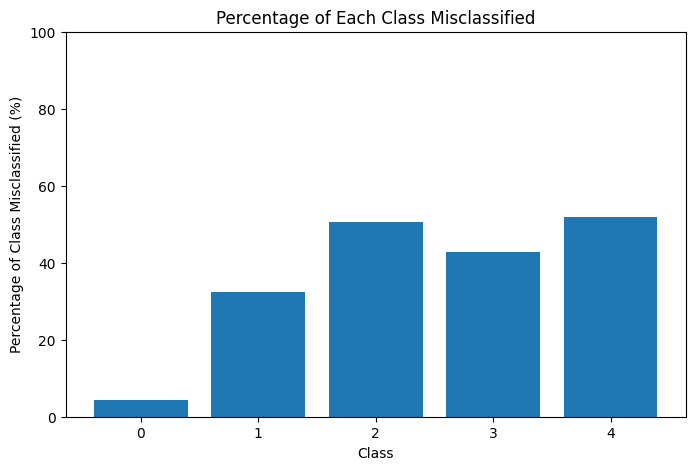

Misclassification percentages per class:
Class 0: 4.35%
Class 1: 32.35%
Class 2: 50.55%
Class 3: 42.86%
Class 4: 51.92%

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       322
           1       0.44      0.68      0.53        68
           2       0.82      0.49      0.62       182
           3       0.28      0.57      0.38        35
           4       0.51      0.48      0.50        52

    accuracy                           0.74       659
   macro avg       0.60      0.64      0.59       659
weighted avg       0.79      0.74      0.75       659



In [ ]:
# After training is done for a fold
final_preds = np.array(results_advanced['trainer'].val_preds)
final_labels = np.array(results_advanced['trainer'].val_labels)

# Evaluate predictions
evaluation_results = evaluate_predictions(final_preds, final_labels)

Loading results file for fold 2 from /content/data/snapshots/fold_2_results.pth.


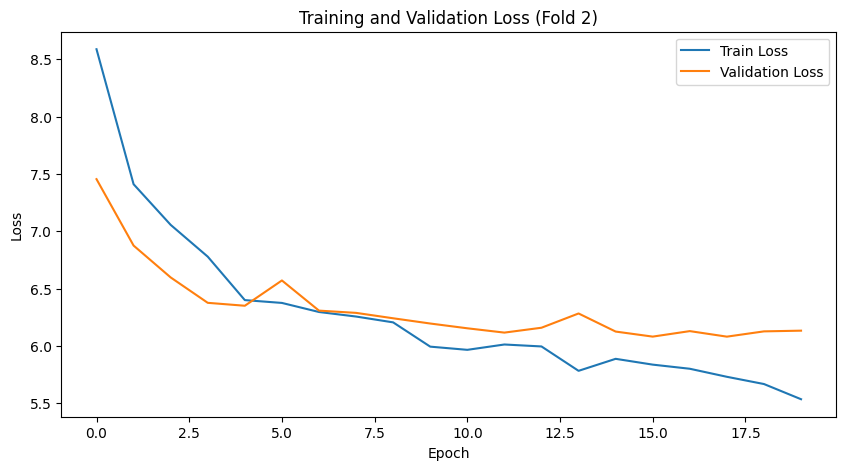

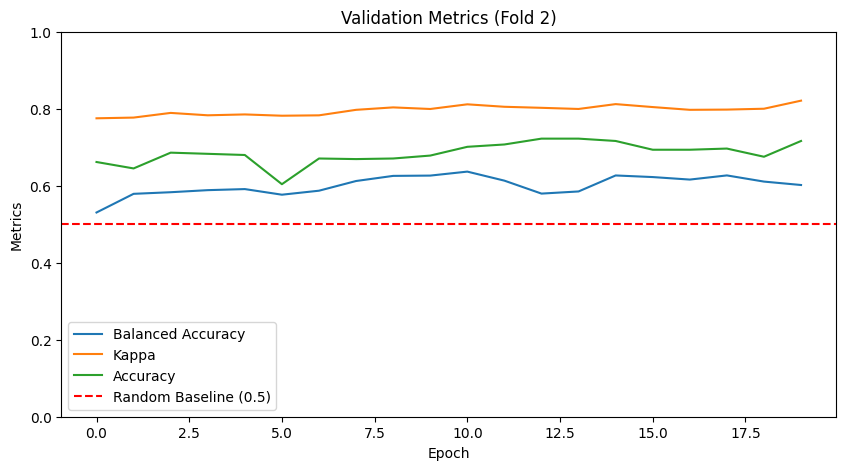

In [ ]:
# Visualize metrics for a specific fold
visualize_fold_results(fold_index=2)